In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import model_5day_functions as model
import matplotlib.colors as colors
from datetime import date
from datetime import datetime
from datetime import timedelta
import seawater as sw
import math
from netCDF4 import Dataset
from scipy import stats
import glob
import xarray as xr
import pandas as pd
from scipy.io import loadmat
from scipy import interpolate
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
#import xlrd
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle


In [2]:
chla_142 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2014_Chl.nc')
chla_152 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2015_Chl.nc')
chla_162 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2016_Chl.nc')

In [73]:
chla_14 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/RedSea_Run2_5day_2014_Chl.nc')
chla_15 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/RedSea_Run2_5day_2015_Chl.nc')
chla_16 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/RedSea_Run2_5day_2016_Chl.nc')

In [71]:
chla = nc.Dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2014_Chl.nc')
chla_14 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/RedSea_Run2_5day_2014_Chl.nc')
chla_15 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/RedSea_Run2_5day_2015_Chl.nc')
chla_16 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/RedSea_Run2_5day_2016_Chl.nc')
salt_14 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/RedSea_Run2_5day_2014_Salt.nc')
salt_15 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2015_Salt.nc')
salt_16 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2016_Salt.nc')
theta_14 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/RedSea_Run2_5day_2014_Theta.nc')
theta_15 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2015_Theta.nc')
theta_16 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2016_Theta.nc')
o2_14 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/RedSea_Run2_5day_2014_O2.nc')
o2_15 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2015_O2.nc')
o2_16 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2016_O2.nc')


FileNotFoundError: [Errno 2] No such file or directory: b'/data/SOSE/SOSE/RedSea/OUTPUT/RedSea_Run2_5day_2014_Chl.nc'

In [52]:
def join_values(trip, value_index, order_index):
    temp_array = []
    for i in range(len(trip['Transect'][0,:])):
        temp_array = np.concatenate((temp_array, trip['Transect'][0,i][value_index][order_index]))
    return(temp_array)
def var_array(var_index):
    trip_1_array = trip_1['Transect'][0,0][var_index][:,:]
    trip_2_array = trip_2['Transect'][0,0][var_index][:,:]
    trip_3_array = trip_3['Transect'][0,0][var_index][:,:]
    for i in range(1, len(trip_1['Transect'][0])):
        trip_1_array = np.concatenate((trip_1_array, trip_1['Transect'][0,i][var_index]),1)
    for i in range(1, len(trip_2['Transect'][0])):
        trip_2_array = np.concatenate((trip_2_array, trip_2['Transect'][0,i][var_index]),1)
    for i in range(1, len(trip_3['Transect'][0])):
        trip_3_array = np.concatenate((trip_3_array, trip_3['Transect'][0,i][var_index]),1)
    return(np.concatenate((trip_1_array, trip_2_array, trip_3_array),1))
trip_1 = loadmat('BG_256_sg213.mat')
trip_2 = loadmat('BG_260_sg214.mat')
trip_3 = loadmat('BG_280_sg212.mat')
trip_1_times = join_values(trip_1,0,0)
trip_2_times = join_values(trip_2,0,0)
trip_3_times = join_values(trip_3,0,0)
total_times = np.concatenate((trip_1_times, trip_2_times, trip_3_times))

trip_1_lats = join_values(trip_1, 2, 1)
trip_1_longs = join_values(trip_1, 1, 1)
trip_2_lats = join_values(trip_2, 2, 1)
trip_2_longs = join_values(trip_2, 1, 1)
trip_3_lats = join_values(trip_3, 2, 1)
trip_3_longs = join_values(trip_3, 1, 1)
total_lats = np.hstack((trip_1_lats, trip_2_lats, trip_3_lats))
total_longs = np.hstack((trip_1_longs, trip_2_longs, trip_3_longs))
total_chla = var_array(6)
total_salinity = var_array(5)
total_temp = var_array(4)
total_o2 = var_array(7)
depth_1 = trip_1['Transect'][0,0][3][:,:]
total_depth1 = depth_1
total_depth = total_depth1[:,0]
for i in range(150):
    total_depth1 = np.concatenate((total_depth1, depth_1[:,1:3]),1)
for i in range(1172):
    total_depth = np.column_stack((total_depth, total_depth1[:,0]))

In [54]:
print(np.shape(total_temp))

(451, 1173)


In [76]:
print(np.shape(total_salinity))
print(np.shape(total_depth))
print(np.shape(total_lats))
pressure = np.empty([451, 1173])
#print(total_depth[:,3])
for i in range(1173):
    pressure[:,i] = sw.eos80.pres(total_depth[:,i], total_lats[i])
print(np.shape(pressure))
#plt.pcolormesh(total_times, total_depth[:,2], pressure)
#plt.colorbar()
total_theta = sw.eos80.ptmp(total_salinity, total_temp, pressure, 0)
print(np.shape(theta))
print(np.shape(total_depth[:,0]))

(451, 1173)
(451, 1173)
(1173,)
(451, 1173)
(451, 1173)
(451,)


In [29]:
theta_g = xr.DataArray(data=theta, dims=['depth', 'time'], coords={'depth': total_depth[:,0], 'time': total_times, 'lat': ('time', total_lats), 'lon': ('time', total_longs)})
chla_g = xr.DataArray(data=total_chla, dims=['depth', 'time'], coords={'depth': total_depth[:,0], 'time': total_times, 'lat': ('time', total_lats), 'lon': ('time', total_longs)})
salt_g = xr.DataArray(data=total_salinity, dims=['depth', 'time'], coords={'depth': total_depth[:,0], 'time': total_times, 'lat': ('time', total_lats), 'lon': ('time', total_longs)})
o2_g = xr.DataArray(data=total_o2, dims=['depth', 'time'], coords={'depth': total_depth[:,0], 'time': total_times, 'lat': ('time', total_lats), 'lon': ('time', total_longs)})

In [30]:
weightsoc = np.empty([50, 2000,2000])
for i in range(50):
    weightsoc[i,:,:] = chla['hFacC'][i,:,:] * chla['rA'] * math.exp((chla['Z'][i])/10) 
for i in range(2000):
    for j in range(2000):
        weightsoc[:,i,j] = weightsoc[:,i,j] * chla['drF']
weights = np.empty([50, 2000,2000])
for i in range(50):
    weights[i,:,:] = chla['hFacC'][i,:,:] * chla['rA'] 
for i in range(2000):
    for j in range(2000):
        weights[:,i,j] = weights[:,i,j] * chla['drF'] 

In [31]:
ncfile = Dataset('/home/pnaylor/RedSea/model_weights_2.nc', mode='w', format = 'NETCDF4_CLASSIC')
depth_dim = ncfile.createDimension('depth', 50)
lat_dim = ncfile.createDimension('lat', 2000)
lon_dim = ncfile.createDimension('lon', 2000)
ncfile.title = 'Model Weights for Statistical Analysis'
weights_oc = ncfile.createVariable('weights_oc', np.float64, ('depth', 'lat', 'lon'))
weights_oc[:,:,:] = weightsoc[:,:,:]
weights_nc = ncfile.createVariable('weights', np.float64, ('depth', 'lat', 'lon'))
weights_nc[:,:,:] = weights
ncfile.close()


PermissionError: [Errno 13] Permission denied: b'/home/pnaylor/RedSea/model_weights_2.nc'

In [ ]:
weights = nc.Dataset('/home/pnaylor/RedSea/model_weights_2.nc')

In [74]:
time_14 = np.array(chla_14['time'])
time_15 = np.array(chla_15['time'])
time_16 = np.array(chla_16['time'])
total_time = np.concatenate((time_14, time_15, time_16))
dates = pd.DatetimeIndex(total_time)
total_months = dates.month
print((total_months))
print(type(dates))

Int64Index([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
            ...
            11, 11, 11, 11, 12, 12, 12, 12, 12, 12],
           dtype='int64', length=217)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [ ]:
#print(chla['time'])
print (date.toordinal(date(2014,1,15)))
day_time = []
for i in range(109):
    day_time.append(735248 + (5*(i+1)))
#print(day_time)
def converted_datenum(times):
    new_times = []
    for i in range(len(times)):
        new_times.append(datetime.fromordinal(int(times[i])))
    return(new_times)
datetimes = converted_datenum(day_time)
months = []
for i in range(70):
    months.append(int(datetimes[i].strftime('%Y%m')))
print(months)

In [6]:
print(chla['Z'][:])

depth = np.flip(np.array(chla['Z'][:]))
print(depth)
a = .71
d1 = 20
d2 = 1
y=[]
for i in range(len(depth)):
    y.append((a*math.exp((depth[i])/d1) + (1-a)*math.exp((depth[i])/d2))*1126)
y = np.flip(y) 
print(y)
drF_weighted = chla['drF']*y 
drF_weighted = np.array(drF_weighted)

[-2.0000e+00 -6.5000e+00 -1.1500e+01 -1.6500e+01 -2.2000e+01 -2.8000e+01
 -3.4500e+01 -4.2000e+01 -5.0000e+01 -5.8500e+01 -6.8000e+01 -7.8500e+01
 -9.0000e+01 -1.0250e+02 -1.1600e+02 -1.3050e+02 -1.4650e+02 -1.6400e+02
 -1.8300e+02 -2.0350e+02 -2.2550e+02 -2.4950e+02 -2.7600e+02 -3.0500e+02
 -3.3600e+02 -3.6950e+02 -4.0600e+02 -4.4600e+02 -4.8950e+02 -5.3650e+02
 -5.8750e+02 -6.4300e+02 -7.0350e+02 -7.6900e+02 -8.4000e+02 -9.1750e+02
 -1.0020e+03 -1.0935e+03 -1.1925e+03 -1.3000e+03 -1.4170e+03 -1.5530e+03
 -1.7030e+03 -1.8530e+03 -2.0280e+03 -2.2280e+03 -2.4280e+03 -2.6530e+03
 -2.9030e+03 -3.1780e+03]
[-3.1780e+03 -2.9030e+03 -2.6530e+03 -2.4280e+03 -2.2280e+03 -2.0280e+03
 -1.8530e+03 -1.7030e+03 -1.5530e+03 -1.4170e+03 -1.3000e+03 -1.1925e+03
 -1.0935e+03 -1.0020e+03 -9.1750e+02 -8.4000e+02 -7.6900e+02 -7.0350e+02
 -6.4300e+02 -5.8750e+02 -5.3650e+02 -4.8950e+02 -4.4600e+02 -4.0600e+02
 -3.6950e+02 -3.3600e+02 -3.0500e+02 -2.7600e+02 -2.4950e+02 -2.2550e+02
 -2.0350e+02 -1.8300e+02 

In [ ]:
def time_mean(data, time_start,depth_ind, ymin, ymax, xmin, xmax, drF):
    #print(0.0)
    temp = []
    sum_weights = np.empty([len(data[:,0,0,0]) - time_start, ymax-ymin, xmax-xmin])
    sum_weights[:,:,:] = 0
    #print(10)
    for i in range(depth_ind):
        sum_weights += (data[time_start:,i,ymin:ymax,xmin:xmax] * drF[i])
    sum_weights = sum_weights / np.sum(drF[:depth_ind])
    sum_weights[sum_weights == 0] = np.float('NaN')
    #print(20)
    for i in range(len(data[time_start:,0,0,0])):
        temp.append(np.nanmean(sum_weights[i,:,:]))
   # print(30)
    return temp

In [ ]:
#plt.figure(figsize = (4,6))

rect1 = plt.Rectangle((234, 1687), 141, 313,color = 'black', fill = None)
rect2 = plt.Rectangle((375, 1583), 165, 397,color = 'black', fill = None)
rect3 = plt.Rectangle((540, 1230), 275, 325,color = 'black', fill = None)
rect4 = plt.Rectangle((730, 875), 300, 345,color = 'black', fill = None)
rect5 = plt.Rectangle((950, 510), 320, 345,color = 'black', fill = None)
rect6 = plt.Rectangle((1120, 250), 250, 260, fill = None)

depth = chla['Depth'][:,:]
depth[depth == 0] = np.float('NaN')
plt.pcolormesh(depth,vmin = 0, vmax = 2500,cmap = 'Wistia',zorder=0)
ax = plt.gca()
#plt.pcolormesh(depth,vmin = 0, vmax = 2500,cmap = 'Wistia')
ax.add_patch(rect1)
ax.annotate('RS1', (234,1787))
ax.add_patch(rect2)
ax.annotate('RS2', (390,1700))
ax.add_patch(rect3)
ax.annotate('RS3', (610, 1350))
ax.add_patch(rect4)
ax.annotate('RS4', (810, 1010))
ax.add_patch(rect5)
ax.annotate('RS5', (1030, 660))
ax.add_patch(rect6)
ax.annotate('RS6', (1170, 360))
ticks = []
ytick_labels = []
xtick_labels = []
for i in range(0,2000,250):
    ticks.append(i)
    ytick_labels.append(round(float(chla['YC'][i]),1))
    xtick_labels.append(round(float(chla['XC'][i]),1))
ticks.append(1999)
ytick_labels.append(round(float(chla['YC'][1999]),1))
xtick_labels.append(round(float(chla['XC'][1999]),1))
ax.set_xticks(ticks)
ax.set_xticklabels(xtick_labels, rotation = 30)
ax.set_yticks(ticks)
ax.set_yticklabels(ytick_labels)
plt.colorbar(label = 'Depth (m)')
plt.title('Data Regions')
plt.savefig('data_regions.png', bbox_inches='tight')

In [7]:
oc_monthly_averages = [np.genfromtxt('OC/january_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/february_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/march_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/april_average_chlorophyll.csv', delimiter=','),np.genfromtxt('OC/may_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/june_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/july_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/august_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/september_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/october_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/november_average_chlorophyll.csv', delimiter=',') ,np.genfromtxt('OC/december_average_chlorophyll.csv', delimiter=',')]

In [8]:
total_months_a = list(total_months)
for i in range(len(total_months)):
    if(i>145):
        total_months_a[i] = total_months[i] + 24
    elif(i>72):
        total_months_a[i] = total_months[i] + 12

In [9]:
list_of_paths = glob.glob('OC/*.nc', recursive=True)
list_of_paths.sort()
oc_1415 = []
for i in range(len(list_of_paths)):
    oc_1415.append(nc.Dataset(list_of_paths[i])['Tchl'][:,:])
for i in range(len(list_of_paths)):
    oc_1415[i][np.isnan(oc_1415[i])] = 0

In [10]:
lat = np.linspace(10.01, 30.0, 1920)
lon = np.linspace(32.01, 44.01, 1152)

In [11]:
for i in range(len(oc_monthly_averages)):
    oc = xr.DataArray(data=np.flip(oc_monthly_averages[i],0), dims=['lat', 'lon'], coords=[lat,lon])
    new_lat = np.linspace(oc.lat[0], oc.lat[-1], 2000)
    new_lon = np.linspace(oc.lon[0], oc.lon[-1], 1200)
    oci = oc.interp(lat=new_lat, lon=new_lon)
    oc_monthly_averages[i] = oci.data
for i in range(12):
    oc_monthly_averages[i][np.isnan(oc_monthly_averages[i])] = 0
for i in range(len(oc_monthly_averages)):
    oc_monthly_averages[i][:250, 900:1000] = 0
    oc_monthly_averages[i][:500, 400:600] = 0
    oc_monthly_averages[i][1250:1500, 0:200] = 0

/home/panaylor/miniconda3/envs/RedSea/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/panaylor/miniconda3/envs/RedSea/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [12]:
oc_xmins = [0, 0, 0, 0]
oc_xmaxs = [1200, 1200, 1200, 1200]
oc_ymins = [280, 750, 1200, 1550]
oc_ymaxs = [750, 1200, 1550, 1785]
oc_ma_1415_tseries = []
for i in range(4):
    temp_1415_tseries = []
    for j in range(len(oc_monthly_averages)):
        try:
            temp_1415_tseries.append(stats.tmean(oc_monthly_averages[j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.000000000001, 100)))
        except:
            temp_1415_tseries.append(np.float('NaN'))
        #print(np.nanmean(oc_monthly_comp_avgs[j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]]))
    oc_ma_1415_tseries.append(temp_1415_tseries)


In [13]:

oc_ma_1415_box_tseries = []
for i in range(4):
    temp_1415_tseries = []
    for j in range(len(total_months)):
        temp_1415_tseries.append(oc_ma_1415_tseries[i][(total_months[j])-1])
    oc_ma_1415_box_tseries.append(temp_1415_tseries)
#plt.plot(oc_1415_box_tseries[3])
oc_ma_1415_box_tseries = np.flip(oc_ma_1415_box_tseries, 0)

In [14]:
list_of_paths = glob.glob('OC/*.nc', recursive=True)
list_of_paths.sort()
oc_1415 = []
for i in range(len(list_of_paths)):
    oc_1415.append(nc.Dataset(list_of_paths[i])['Tchl'][:,:])
for i in range(len(list_of_paths)):
    oc_1415[i][np.isnan(oc_1415[i])] = 0

#print(chla['XC'][200])



for i in range(len(oc_1415)):
    oc = xr.DataArray(data=np.flip(oc_1415[i],0), dims=['lat', 'lon'], coords=[lat,lon])
    new_lat = np.linspace(oc.lat[0], oc.lat[-1], 2000)
    new_lon = np.linspace(oc.lon[0], oc.lon[-1], 1200)
    oci = oc.interp(lat=new_lat, lon=new_lon)
    oc_1415[i] = oci.data

    
for i in range(len(oc_1415)):
    oc_1415[i][:250, 900:1000] = 0
    oc_1415[i][:500, 400:600] = 0
    oc_1415[i][1250:1500, 0:200] = 0

In [15]:
oc_monthly_comp_avgs = []

for month in total_months:
    index = month  
    oc_monthly_comp_avgs.append(oc_monthly_averages[index-1])
for i in range(len(oc_monthly_comp_avgs)):
    oc_monthly_comp_avgs[i][np.isnan(oc_monthly_comp_avgs[i])] = 0

In [16]:
oc_xmins = [0, 0, 0, 0]
oc_xmaxs = [1200, 1200, 1200, 1200]
oc_ymins = [280, 750, 1200, 1550]
oc_ymaxs = [750, 1200, 1550, 1785]
oc_1415_tseries = []
for i in range(4):
    temp_1415_tseries = []
    for j in range(len(oc_1415)):
        try:
            temp_1415_tseries.append(stats.tmean(oc_1415[j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.0, 100), (False, False)))
        except:
            temp_1415_tseries.append(np.float('NaN'))
        #print(np.nanmean(oc_monthly_comp_avgs[j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]]))
    oc_1415_tseries.append(temp_1415_tseries)


In [17]:

total_months_a = list(total_months)
for i in range(len(total_months)):
    if(i>140):
        total_months_a[i] = total_months[i] + 24
    elif(i>67):
        total_months_a[i] = total_months[i] + 12

In [18]:
print(np.shape(oc_1415_tseries))
print(np.shape(total_months_a))

(4, 54)
(217,)


(0.0, 0.35)

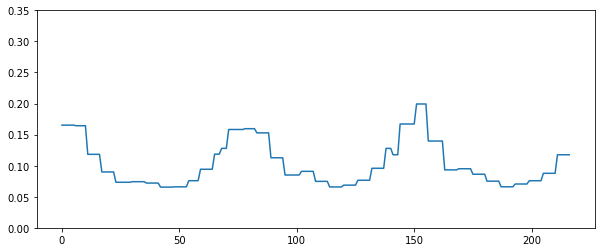

In [19]:
plt.figure(1, figsize = (10,4))
oc_1415_box_tseries = []
for i in range(4):
    temp_1415_tseries = []
    for j in range(len(total_months)):
        temp_1415_tseries.append(oc_1415_tseries[i][(total_months_a[j])-1])
    oc_1415_box_tseries.append(temp_1415_tseries)
plt.plot(oc_1415_box_tseries[3])
oc_1415_box_tseries = np.flip(oc_1415_box_tseries, 0)
plt.ylim([0,.35])

In [20]:
print(np.shape(oc_1415_box_tseries[3]))

(217,)


In [21]:
oc_1415_box_tseries = np.flip(oc_1415_box_tseries, 0)

In [22]:
depth = chla['Depth'][:,:]
shore_depth = depth
shore_depth[shore_depth > 500] = 0
shore_depth[(shore_depth <= 500) & (shore_depth > 0)] = 1
shore_chla14 = np.array(chla_14['BLGCHL'][:,:,:,:])
shore_chla14[:,:,1200:,:] = np.array(chla_14['BLGCHL'][:,:,1200:,:] * shore_depth[1200:,:])
shore_chla15 = np.array(chla_15['BLGCHL'][:,:,:,:])
shore_chla15[:,:,1200:,:] = np.array(chla_15['BLGCHL'][:,:,1200:,:] * shore_depth[1200:,:])
shore_chla16 = np.array(chla_16['BLGCHL'][:,:,:,:])
shore_chla16[:,:,1200:,:] = np.array(chla_16['BLGCHL'][:,:,1200:,:] * shore_depth[1200:,:])

In [23]:
depth = chla['Depth'][:,:]
offshore_depth = depth
offshore_depth[offshore_depth <= 500] = 0
offshore_depth[offshore_depth > 500] = 1
offshore_chla14 = np.array(chla_14['BLGCHL'][:,:,:,:])
offshore_chla14[:,:,1200:,:] = np.array(chla_14['BLGCHL'][:,:,1200:,:] * offshore_depth[1200:,:])
offshore_chla15 = np.array(chla_15['BLGCHL'][:,:,:,:])
offshore_chla15[:,:,1200:,:] = np.array(chla_15['BLGCHL'][:,:,1200:,:] * offshore_depth[1200:,:])
offshore_chla16 = np.array(chla_16['BLGCHL'][:,:,:,:])
offshore_chla16[:,:,1200:,:] = np.array(chla_16['BLGCHL'][:,:,1200:,:] * offshore_depth[1200:,:])

In [24]:
depth = chla['Depth'][:,:]
offshore200_depth = depth
offshore200_depth[offshore200_depth <= 200] = 0
offshore200_depth[offshore200_depth > 200] = 1
offshore_chla14[:,:,:1200,:] = np.array(chla_14['BLGCHL'][:,:,:1200,:] * offshore200_depth[:1200,:])
offshore_chla15[:,:,:1200,:] = np.array(chla_15['BLGCHL'][:,:,:1200,:] * offshore200_depth[:1200,:])
offshore_chla16[:,:,:1200,:] = np.array(chla_16['BLGCHL'][:,:,:1200,:] * offshore200_depth[:1200,:])

In [25]:
depth = chla['Depth'][:,:]
shore200_depth = depth
shore200_depth[shore200_depth > 200] = 0
shore200_depth[(shore200_depth <= 200) & (shore200_depth > 0)] = 1
shore_chla14[:,:,:1200,:] = np.array(chla_14['BLGCHL'][:,:,:1200,:] * shore200_depth[:1200,:])
shore_chla15[:,:,:1200,:] = np.array(chla_15['BLGCHL'][:,:,:1200,:] * shore200_depth[:1200,:])
shore_chla16[:,:,:1200,:] = np.array(chla_16['BLGCHL'][:,:,:1200,:] * shore200_depth[:1200,:])

In [26]:
shore_oc_1415 = []
offshore_oc_1415 = []
shore200_oc_1415 = []
offshore200_oc_1415 = []
shore_oc_ma_1415 = []
offshore_oc_ma_1415 = []
shore200_oc_ma_1415 = []
offshore200_oc_ma_1415 = []
for i in range(len(oc_1415)):
    shore_oc_1415.append(oc_1415[i] * shore_depth[:, 200:1400])
    offshore_oc_1415.append(oc_1415[i] * offshore_depth[:, 200:1400])
    shore200_oc_1415.append(oc_1415[i] * shore200_depth[:, 200:1400])
    offshore200_oc_1415.append(oc_1415[i] * offshore200_depth[:, 200:1400])
for i in range(12):
    shore_oc_ma_1415.append(oc_monthly_averages[i] * shore_depth[:, 200:1400])
    offshore_oc_ma_1415.append(oc_monthly_averages[i] * offshore_depth[:, 200:1400])
    shore200_oc_ma_1415.append(oc_monthly_averages[i] * shore200_depth[:, 200:1400])
    offshore200_oc_ma_1415.append(oc_monthly_averages[i] * offshore200_depth[:, 200:1400])

In [27]:
shore_oc_dl = [shore_oc_1415, shore_oc_1415, shore200_oc_1415, shore200_oc_1415]
offshore_oc_dl = [offshore_oc_1415, offshore_oc_1415, offshore200_oc_1415, offshore200_oc_1415]
shore_oc_ma_dl = [shore_oc_ma_1415, shore_oc_ma_1415, shore200_oc_ma_1415, shore200_oc_ma_1415]
offshore_oc_ma_dl = [offshore_oc_ma_1415, offshore_oc_ma_1415, offshore200_oc_ma_1415, offshore200_oc_ma_1415]

In [28]:
def time_mean(data, time_start,depth_ind, ymin, ymax, xmin, xmax, drF):
    temp = []
    sum_weights = np.empty([len(data[:,0,0,0]) - time_start, ymax-ymin, xmax-xmin])
    sum_weights[:,:,:] = 0
    for i in range(depth_ind):
        sum_weights += (data[time_start:,i,ymin:ymax,xmin:xmax] * drF[i])
    sum_weights = sum_weights / np.sum(drF[:depth_ind])
    sum_weights[sum_weights == 0] = np.float('NaN')
    for i in range(len(data[time_start:,0,0,0])):
        temp.append(np.nanmean(sum_weights[i,:,:]))
    return temp

In [29]:
print(len(total_months))

217


1
0
a
b
c
d
e
f
g
h
0.25
0
a
b
c
d
e
f
g
h
0.5
0
a
b
c
d
e
f
g
h
0.75
0
a
b
c
d
e
f
g
h
1.0
2
0.25
0.5
0.75
1.0
3
0.0
0.25
0.5
0.75


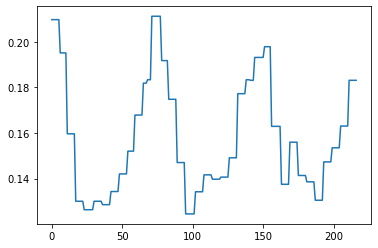

In [30]:
xmins = [0, 0, 0, 0]
xmaxs = [2000, 2000, 2000, 2000]
ymins = [280, 750, 1200, 1550]
ymaxs = [750, 1200, 1550, 1785]
shore_model_box_arrays = []
offshore_model_box_arrays = []
print(1)
for i in range(4):
    print('0')
    shore_temp_14 = np.array(time_mean(np.array(shore_chla14), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('a')
    shore_temp_15 = np.array(time_mean(np.array(shore_chla15), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('b')
    shore_temp_16 = np.array(time_mean(np.array(shore_chla16), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('c')
    offshore_temp_14 = np.array(time_mean(np.array(offshore_chla14), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('d')
    offshore_temp_15 = np.array(time_mean(np.array(offshore_chla15), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('e')
    offshore_temp_16 = np.array(time_mean(np.array(offshore_chla16), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('f')
    #print((temp_14), (temp_15))
    shore_model_box_arrays.append(np.concatenate([shore_temp_14,shore_temp_15, shore_temp_16]))
    print('g')
    offshore_model_box_arrays.append(np.concatenate([offshore_temp_14,offshore_temp_15, offshore_temp_16]))
    print('h')
    print((i+1)/4)
oc_xmins = [0, 0, 0, 0]
oc_xmaxs = [1200, 1200, 1200, 1200]
oc_ymins = [280, 750, 1200, 1550]
oc_ymaxs = [750, 1200, 1550, 1785]
shore_oc_1415_tseries = []
offshore_oc_1415_tseries = []
shore_oc_ma_1415_tseries = []
offshore_oc_ma_1415_tseries = []
print(2)
for i in range(4):
    shore_temp_1415_tseries = []
    offshore_temp_1415_tseries = []
    shore_temp_ma_1415_tseries = []
    offshore_temp_ma_1415_tseries = []
    for j in range(len(oc_1415)):
        try:
            shore_temp_1415_tseries.append(stats.tmean(shore_oc_dl[i][j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.000000000001, 100)))
        except:
            shore_temp_1415_tseries.append(np.float('NaN'))
        try:
            offshore_temp_1415_tseries.append(stats.tmean(offshore_oc_dl[i][j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.000000000001, 100)))
        except:
            offshore_temp_1415_tseries.append(np.float('NaN'))
        try:
            shore_temp_ma_1415_tseries.append(stats.tmean(shore_oc_ma_dl[i][j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.000000000001, 100)))            
        except:
            shore_temp_ma_1415_tseries.append(np.float('NaN'))
        try:
            offshore_temp_ma_1415_tseries.append(stats.tmean(offshore_oc_ma_dl[i][j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.000000000001, 100)))
        except:
            offshore_temp_ma_1415_tseries.append(np.float('NaN'))
        #print(np.nanmean(oc_monthly_comp_avgs[j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]]))
    shore_oc_1415_tseries.append(shore_temp_1415_tseries)
    offshore_oc_1415_tseries.append(offshore_temp_1415_tseries)
    shore_oc_ma_1415_tseries.append(shore_temp_ma_1415_tseries)
    offshore_oc_ma_1415_tseries.append(offshore_temp_ma_1415_tseries)
    print((i+1)/4)

shore_oc_1415_box_tseries = []
offshore_oc_1415_box_tseries = []
shore_oc_ma_1415_box_tseries = []
offshore_oc_ma_1415_box_tseries = []
print(3)
for i in range(4):
    shore_temp_1415_tseries = []
    offshore_temp_1415_tseries = []
    shore_temp_ma_1415_tseries = []
    offshore_temp_ma_1415_tseries = []
    for j in range(len(total_months)):
        shore_temp_1415_tseries.append(shore_oc_1415_tseries[i][(total_months_a[j])-1])
        offshore_temp_1415_tseries.append(offshore_oc_1415_tseries[i][(total_months_a[j])-1])
        shore_temp_ma_1415_tseries.append(shore_oc_ma_1415_tseries[i][(total_months[j])-1])
        offshore_temp_ma_1415_tseries.append(offshore_oc_ma_1415_tseries[i][(total_months[j])-1])
    shore_oc_1415_box_tseries.append(shore_temp_1415_tseries)
    offshore_oc_1415_box_tseries.append(offshore_temp_1415_tseries)
    shore_oc_ma_1415_box_tseries.append(shore_temp_ma_1415_tseries)
    offshore_oc_ma_1415_box_tseries.append(offshore_temp_ma_1415_tseries)
    print(i/4)
plt.plot(shore_oc_1415_box_tseries[3])

4


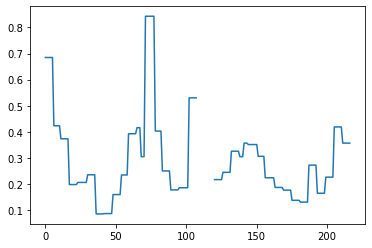

In [31]:
print(len(shore_oc_1415_tseries))
#plt.plot(shore_oc_1415_box_tseries[3])
shore_oc_1415_final = []
offshore_oc_1415_final = []
shore_oc_ma_1415_final = []
offshore_oc_ma_1415_final = []
for i in range(1,5):
    shore_oc_1415_final.append(shore_oc_1415_box_tseries[-i])
    offshore_oc_1415_final.append(offshore_oc_1415_box_tseries[-i])
    shore_oc_ma_1415_final.append(shore_oc_ma_1415_box_tseries[-i])
    offshore_oc_ma_1415_final.append(offshore_oc_ma_1415_box_tseries[-i])
plt.plot(offshore_oc_1415_final[3])

In [32]:
shore_model_box_array_final = []
offshore_model_box_array_final = []
for i in range(1,5):
    shore_model_box_array_final.append(shore_model_box_arrays[-i])
    offshore_model_box_array_final.append(offshore_model_box_arrays[-i])

In [33]:

off4 = np.linspace(0,len(total_months)-1,len(total_months))
off4[:] = np.float('NaN')
print(off4)
offshore_oc_1415_final[3] = off4
shore_oc_1415_final[3] = off4
print(offshore_oc_1415_final[3])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

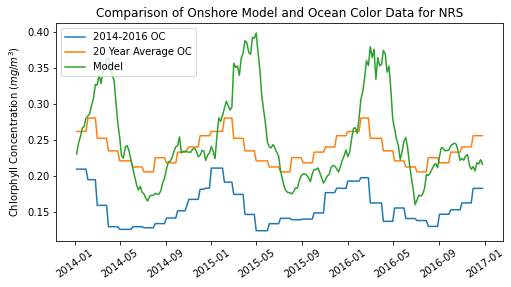

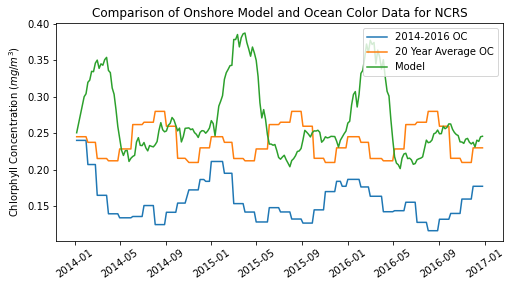

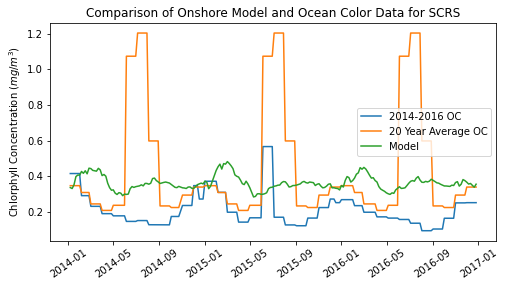

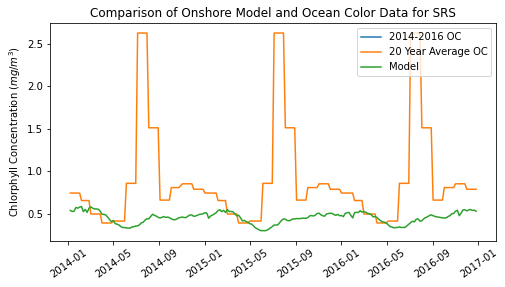

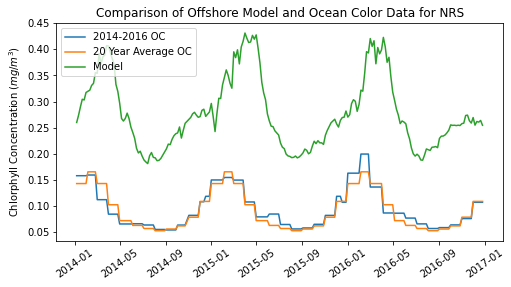

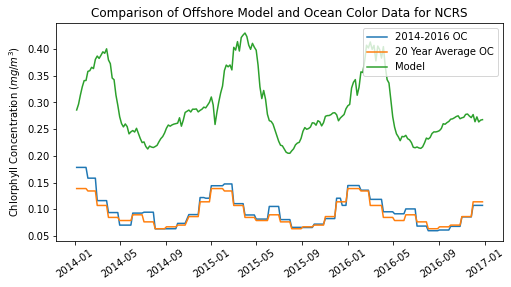

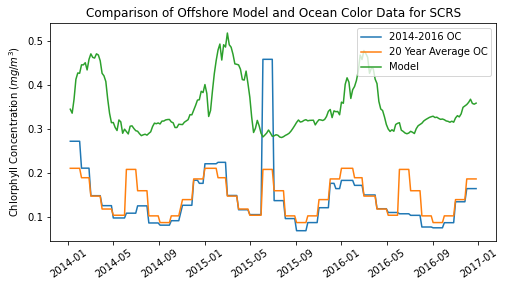

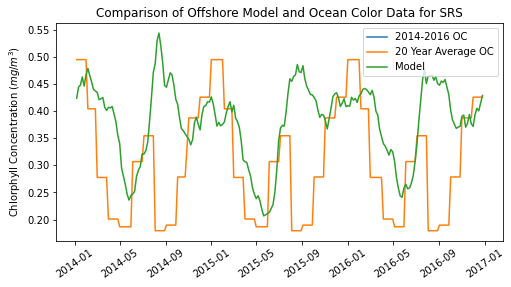

In [34]:
regions = ['N', 'NC', 'SC', 'S']
for i in range(4):
    plt.figure(i, figsize=(8,4))
    plt.plot(total_time, shore_oc_1415_final[i])
    plt.plot(total_time, shore_oc_ma_1415_final[i])
    plt.plot(total_time, shore_model_box_array_final[i])
    plt.legend(['2014-2016 OC', '20 Year Average OC', 'Model'])
    plt.ylabel(r'Chlorphyll Concentration ($mg/m^3$)') 
    plt.xticks(rotation = 35)
    plt.title('Comparison of Onshore Model and Ocean Color Data for {}RS'.format(regions[i]))
    plt.savefig('modeloc1415on2_{}RS.png'.format(regions[i]), bbox_inches = 'tight')

for i in range(4):
    plt.figure(i+4, figsize=(8,4))
    plt.plot(total_time, offshore_oc_1415_final[i])
    plt.plot(total_time, offshore_oc_ma_1415_final[i])
    plt.plot(total_time, offshore_model_box_array_final[i])
    plt.legend(['2014-2016 OC', '20 Year Average OC', 'Model'])
    plt.ylabel(r'Chlorphyll Concentration ($mg/m^3$)') 
    plt.title('Comparison of Offshore Model and Ocean Color Data for {}RS'.format(regions[i]))
    plt.xticks(rotation = 35)
    plt.savefig('modeloc1415off2_{}RS.png'.format(regions[i]), bbox_inches = 'tight')

In [35]:
time_14 = np.array(chla_14['time'])
time_15 = np.array(chla_15['time'][:])
time_16 = np.array(chla_16['time'])
total_time = np.concatenate((time_14, time_15, time_16))
dates = pd.DatetimeIndex(total_time)
total_months = dates.month
print((total_months))
print(type(dates))

Int64Index([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
            ...
            11, 11, 11, 11, 12, 12, 12, 12, 12, 12],
           dtype='int64', length=217)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [36]:
oc_xmins = [0, 0, 0, 0]
oc_xmaxs = [1200, 1200, 1200, 1200]
oc_ymins = [280, 750, 1200, 1550]
oc_ymaxs = [750, 1200, 1550, 1785]

[   0.  500. 1000. 1500. 2000.]


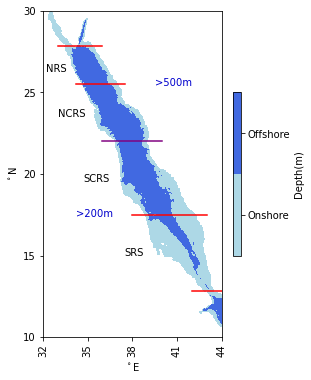

In [25]:
plt.figure(1, figsize = (4,6))
depth = np.array(chla_14['Depth'][:,:])
depth[1550:,:][(depth[1550:,:] <= 500) & (depth[1550:,:] > 0)] = 1
depth[1550:,:][depth[1550:,:] > 500] = 2
depth[:1550,:][(depth[:1550,:] <= 200) & (depth[:1550,:] > 0)] = 1
depth[:1550,:][depth[:1550,:] > 200] = 2
depth[depth == 0] = np.float('NaN')
depth = depth[:, 200:1400]
colors = ['lightblue','lightblue','royalblue', 'royalblue']
nodes = [0,.5, .5, 1]
cmap2 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes,colors)))
xticks = np.linspace(0,1200,5)
yticks = np.linspace(0,2000,5)
print(yticks)
xlabels = [int(chla_14['XC'][int(xticks[0] + 200)]),int(chla_14['XC'][int(xticks[1] + 200)]), int(chla_14['XC'][int(xticks[2] + 200)]), int(chla_14['XC'][int(xticks[3] + 200)]), int(chla_14['XC'][int(xticks[4]+200)])]
ylabels = [int(chla_14['YC'][int(yticks[0])]),int(chla_14['YC'][int(yticks[1]-1)]), int(chla_14['YC'][int(yticks[2]-1)]), int(chla_14['YC'][int(yticks[3]-1)]), int(chla_14['YC'][int(yticks[4]-1)])]
#print(xticks, yticks, xlabels, ylabels)                                                                 
plt.pcolormesh(depth, cmap = cmap2, vmin = .5, vmax = 2.5)
cbar = plt.colorbar(ticks=[1,2], label = 'Depth(m)', shrink=.5)
cbar.ax.set_yticklabels(['Onshore', 'Offshore'])
plt.xticks(xticks, labels=xlabels, rotation=90)
plt.yticks(yticks, labels=ylabels)
#plt.scatter([425], [1450], c='r')
#plt.legend(['Float Range'])
x1 = [1000, 1200]
y1 = [280, 280]
x2 = [600, 1100]
y2 = [750, 750]
x3 = [400, 800]
y3 = [1200, 1200]
x4 = [225, 550]
y4 = [1550, 1550]
x5 = [100, 400]
y5 = [1785, 1785]
x6 = [700, 1200]
y6 = [500, 500]
plt.plot(x1, y1, c='r')
plt.plot(x2, y2, c='r')
plt.plot(x3, y3, c= 'purple')
plt.plot(x4, y4, c='r')
plt.plot(x5, y5, c='r')
#plt.plot(x6, y6, c='r', linestyle=':')
plt.annotate('NRS', (20,1625))
plt.annotate('NCRS', (100,1350))
plt.annotate('SCRS', (275,950))
plt.annotate('SRS', (550,500))
plt.annotate('>500m', (750, 1540), c='mediumblue')
plt.annotate('>200m', (225, 740), c='mediumblue')
plt.xlabel(r'$^\circ$E')
plt.ylabel(r'$^\circ$N')

plt.savefig('updated_regions_map_flux.png', bbox_inches='tight')

0      1126.362953
1       901.911695
2       868.169463
3       851.637107
4       771.549488
          ...     
995            NaN
996            NaN
997            NaN
998            NaN
999            NaN
Name: PAR, Length: 1000, dtype: float64
0.003132062642525815
767.5737056111117
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 1

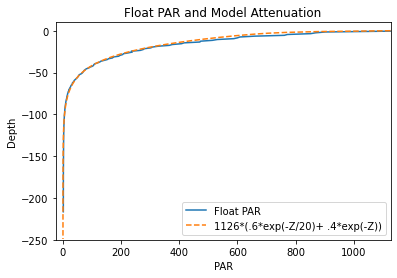

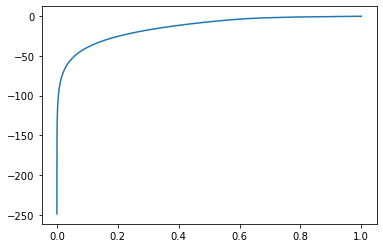

In [2]:
central_float = pd.read_csv('/home/panaylor/RedSea/ssh_redsea/floats_central_data_cal.csv')
avg = central_float.groupby('PRES').PAR.mean().reset_index()
print(avg.PAR)
plt.plot(avg.PAR, -avg.PRES)
x = range(0,250, 1)
y=[]
a = .71
d1 = 20
d2 = 1
for i in range(len(x)):
    y.append((a*math.exp((-x[i])/d1) + (1-a)*math.exp((-x[i])/d2))*1126)
plt.plot(y,-1*np.array(x), linestyle='--')
plt.ylim([-250, 10])
plt.xlim([-25, 1126])
plt.legend(['Float PAR', '1126*(.6*exp(-Z/20)+ .4*exp(-Z))'])
plt.xlabel('PAR')
plt.ylabel('Depth')
plt.title('Float PAR and Model Attenuation')
plt.savefig('/home/panaylor/RedSea/ssh_redsea/figures/Float_Par.png')
plt.figure(2)
plt.plot(np.array(y)/1126,-1*np.array(x))
print(y[-1])
print(y[2])
print(list(x))

In [3]:
nfloat_meta = pd.read_csv('/home/panaylor/RedSea/ssh_redsea/nfloat_meta.csv')
nfloat_chla = np.loadtxt('/home/panaylor/RedSea/ssh_redsea/nfloat_chla.csv',dtype=str, delimiter=',')
nfloat_temp = np.loadtxt('/home/panaylor/RedSea/ssh_redsea/nfloat_temp.csv',dtype=str, delimiter=',')
nfloat_salt = np.loadtxt('/home/panaylor/RedSea/ssh_redsea/nfloat_salt.csv',dtype=str, delimiter=',')
nfloat_o2 = np.loadtxt('/home/panaylor/RedSea/ssh_redsea/nfloat_o2.csv',dtype=str, delimiter=',')

In [4]:
nfloat_chla[nfloat_chla == 'NA'] = np.float('NaN')
nfloat_chla = nfloat_chla.astype('float64')
nfloat_temp[nfloat_temp == 'NA'] = np.float('NaN')
nfloat_temp = nfloat_temp.astype('float64')
nfloat_salt[nfloat_salt == 'NA'] = np.float('NaN')
nfloat_salt = nfloat_salt.astype('float64')
nfloat_o2[nfloat_o2 == 'NA'] = np.float('NaN')
nfloat_o2 = nfloat_o2.astype('float64')
nfloat_theta = sw.eos80.ptmp(nfloat_salt, nfloat_temp, nfloat_meta['Pressure'][:168], 0)

In [5]:
nDates = nfloat_meta['Dates'][:168]
for i in range(168):
    nDates[i] = pd.to_datetime(nDates[i], format= '%d-%b-%y')
print(nDates)

0      2015-09-30 00:00:00
1      2015-10-01 00:00:00
2      2015-10-02 00:00:00
3      2015-10-03 00:00:00
4      2015-10-04 00:00:00
              ...         
163    2017-01-30 00:00:00
164    2017-02-04 00:00:00
165    2017-02-09 00:00:00
166    2017-02-14 00:00:00
167    2017-02-19 00:00:00
Name: Dates, Length: 168, dtype: object


In [6]:
def depth_avgs(data, time_start, depth_ind, ymin, ymax, xmin, xmax):
    sum=0
    depth = depth_ind+1
    time = len(data[time_start:,0,0,0])
    temp = np.empty([depth,time])
    for i in range(time):
        for j in range(depth):
            try: 
                temp[j,i] = stats.tmean(data[time_start + i,j,ymin:ymax, xmin:xmax], (0.00000000000000000000000001, 1000))
            except:
                temp[j,i] = np.float('NaN')
                sum+=1
                print(sum)
    return temp

In [7]:
theta_nf = xr.DataArray(data=nfloat_theta, dims=['time', 'depth'], coords={'depth': -nfloat_meta['Pressure'][:168], 'time': nfloat_meta['Dates'], 'lat': ('time', nfloat_meta['Latitude']), 'lon': ('time', nfloat_meta['Longitude'])})
chla_nf = xr.DataArray(data=nfloat_chla, dims=['time', 'depth'], coords={'depth': -nfloat_meta['Pressure'][:168], 'time': nfloat_meta['Dates'], 'lat': ('time', nfloat_meta['Latitude']), 'lon': ('time', nfloat_meta['Longitude'])})
salt_nf = xr.DataArray(data=nfloat_salt, dims=['time', 'depth'], coords={'depth': -nfloat_meta['Pressure'][:168], 'time': nfloat_meta['Dates'], 'lat': ('time', nfloat_meta['Latitude']), 'lon': ('time', nfloat_meta['Longitude'])})
o2_nf = xr.DataArray(data=nfloat_o2, dims=['time', 'depth'], coords={'depth': -nfloat_meta['Pressure'][:168], 'time': nfloat_meta['Dates'], 'lat': ('time', nfloat_meta['Latitude']), 'lon': ('time', nfloat_meta['Longitude'])})

In [63]:
chla14_da_nfr1 =  depth_avgs(chla_142['BLGCHL'], 0 ,20, 1660, 1760, 420, 480)
chla16_da_nfr2 = depth_avgs(chla_16['BLGCHL'], 0 ,20, 1660, 1760, 420, 480)
chla14_da_nfr2 =  depth_avgs(chla_14['BLGCHL'], 0 ,20, 1660, 1760, 420, 480)
chla15_da_nfr1 =  depth_avgs(chla_152['BLGCHL'],0,20, 1660, 1760, 420, 480)
chla15_da_nfr2 =  depth_avgs(chla_15['BLGCHL'],0,20, 1660, 1760, 420, 480)
chla16_da_nfr1 = depth_avgs(chla_15['BLGCHL'],0,20,1660, 1760,420, 480)
r1_time = np.concatenate((chla_142['time'][:], chla_152['time'][:], chla_162['time'][:]))
r2_time = total_time[:]
chla_da_nfr1 = np.concatenate((chla14_da_nfr1, chla15_da_nfr1[:,:], chla16_da_nfr1),1)
chla_da_nfr2 = np.concatenate((chla14_da_nfr2, chla15_da_nfr2[:,:], chla16_da_nfr2[:,:]),1)

In [80]:
no3 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/RedSea_Run2_5day_2016_NO3.nc')

In [14]:
theta_14 = xr.open_dataset('/data/SOSE/SOSE/RedSea/TMP/RedSea_NoBlngPtrcrLevsStrat_5day_2014_Theta.nc')
salt_14 = xr.open_dataset('/data/SOSE/SOSE/RedSea/TMP/RedSea_NoBlngPtrcrLevsStrat_5day_2014_Salt.nc')
salt_da_nf = depth_avgs(salt_14['SALT'], 0 ,49, 1660, 1760, 420, 480)
theta_da_nf = depth_avgs(theta_14['THETA'], 0 ,49, 1660, 1760, 420, 480)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


<ipython-input-106-b5b4609797fa>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_temp[:,:],cmap='jet', vmin = 22, vmax = 25)
<ipython-input-106-b5b4609797fa>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_salt[:,:],cmap='YlGnBu', vmin = 40.15, vmax = 40.65)


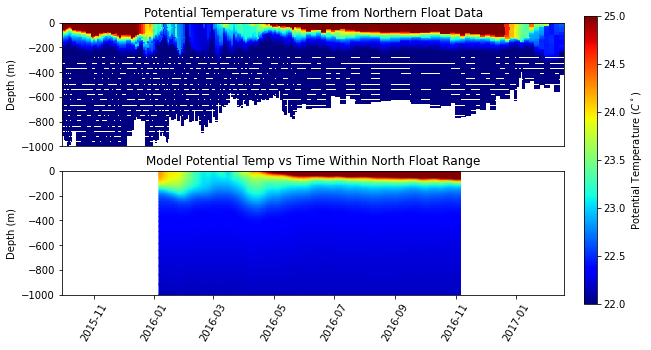

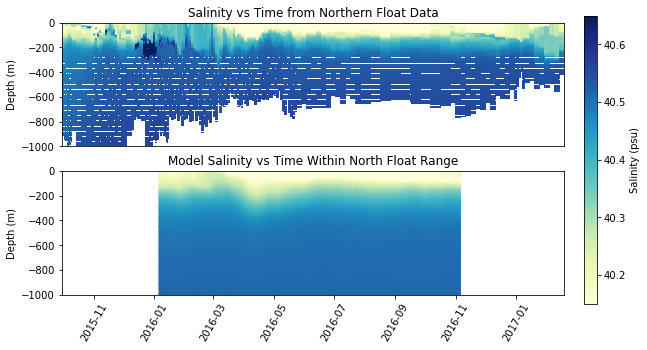

In [106]:
nDates_array = np.array(nDates)
fig = plt.figure(2, figsize=(9,5))
plt.subplot(2,1,1)
im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_temp[:,:],cmap='jet', vmin = 22, vmax = 25)
plt.ylim([-1000, 0])
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.xticks([])
plt.title('Potential Temperature vs Time from Northern Float Data')
plt.ylabel('Depth (m)')
plt.xlim([nDates_array[0], nDates_array[-1]])
plt.subplot(2,1,2)
#plt.savefig('Temp_nfloat.png', bbox_inches='tight')
im2 = plt.pcolormesh(no3['time'][:62], theta_14['Z'][:], theta_da_nf, cmap = 'jet', shading = 'Gouraud',vmin=22, vmax=25)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Model Potential Temp vs Time Within North Float Range')
plt.xlim([nDates_array[0], nDates_array[-1]])
plt.ylim([-1000, 0])
cb_ax = fig.add_axes([.93, .1, .02, .8])
fig.colorbar(im, cax=cb_ax, label =  r'Potential Temperature ($C^\circ$)')
plt.savefig('modelstrat_2_theta_comp_timeseries_nf.png', bbox_inches = 'tight')

fig = plt.figure(3, figsize=(9,5))
plt.subplot(2,1,1)
im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_salt[:,:],cmap='YlGnBu', vmin = 40.15, vmax = 40.65)
plt.ylim([-1000, 0])
#plt.colorbar(label = 'Salinity (PSU)')
plt.xticks([])
plt.xlim([nDates_array[0], nDates_array[-1]])
plt.title('Salinity vs Time from Northern Float Data')
plt.ylabel('Depth (m)')
#plt.savefig('Salt_nfloat.png', bbox_inches='tight')
plt.subplot(2,1,2)
im2 = plt.pcolormesh(no3['time'][:62], theta_14['Z'][:], salt_da_nf, vmin=40.15, vmax=40.65, cmap = 'YlGnBu', shading = 'Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = 'Salinity (psu)')
plt.title('Model Salinity vs Time Within North Float Range')
plt.xlim([nDates_array[0], nDates_array[-1]])
plt.ylim([-1000, 0])
cb_ax = fig.add_axes([.93, .1, .02, .8])
fig.colorbar(im, cax=cb_ax, label = 'Salinity (psu)')
plt.savefig('modelstrat_2_salt_comp_timeseries_nf.png', bbox_inches = 'tight')

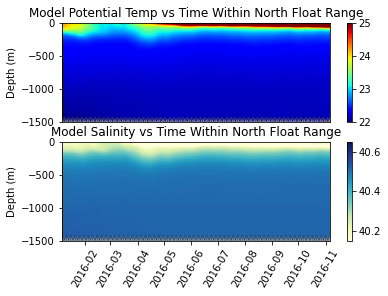

In [105]:
fig = plt.figure(1)
plt.subplot(2,1,1)
#plt.savefig('Temp_nfloat.png', bbox_inches='tight')
im2 = plt.pcolormesh(no3['time'][:62], theta_14['Z'][:], theta_da_nf, cmap = 'jet', shading = 'Gouraud',vmin=22, vmax=25)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Model Potential Temp vs Time Within North Float Range')
#plt.xlim([nDates_array[0], nDates_array[-1]])
plt.xticks([])
plt.ylim([-1500, 0])
plt.colorbar()

plt.subplot(2,1,2)
im2 = plt.pcolormesh(no3['time'][:62], theta_14['Z'][:], salt_da_nf, vmin=40.15, vmax=40.65, cmap = 'YlGnBu', shading = 'Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = 'Salinity (psu)')
plt.title('Model Salinity vs Time Within North Float Range')
#plt.xlim([nDates_array[0], nDates_array[-1]])
plt.ylim([-1500,0])
plt.colorbar()
plt.savefig('figures/stratmodel_nf.png', bbox_inches='tight')

In [45]:
chla14_da_nf =  depth_avgs(chla_14['BLGCHL'], 0 ,20, 1660, 1760, 420, 480)
chla15_da_nf =  depth_avgs(chla_15['BLGCHL'], 0 ,20, 1660, 1760, 420, 480)
chla16_da_nf =  depth_avgs(chla_16['BLGCHL'], 0 ,20, 1660, 1760, 420, 480)
print(1/4)

salt14_da_nf = depth_avgs(salt_14['SALT'], 0 ,20, 1660, 1760, 420, 480)
salt15_da_nf = depth_avgs(salt_15['SALT'], 0 ,20, 1660, 1760, 420, 480)
salt16_da_nf = depth_avgs(salt_16['SALT'], 0 ,20, 1660, 1760, 420, 480)
print(2/4)

o214_da_nf = depth_avgs(o2_14['TRAC03'], 0 ,20, 1660, 1760, 420, 480)
o215_da_nf = depth_avgs(o2_15['TRAC03'], 0 ,20, 1660, 1760, 420, 480)
o216_da_nf = depth_avgs(o2_16['TRAC03'], 0 ,20, 1660, 1760, 420, 480)
print(3/4)

theta14_da_nf = depth_avgs(theta_14['THETA'], 0 ,20, 1660, 1760, 420, 480)
theta15_da_nf = depth_avgs(theta_15['THETA'], 0 ,20, 1660, 1760, 420, 480)
theta16_da_nf = depth_avgs(theta_16['THETA'], 0 ,20, 1660, 1760, 420, 480)
print(4/4)

0.25
0.5
0.75
1.0


In [46]:
chla_da_nf = np.concatenate([chla14_da_nf, chla15_da_nf, chla16_da_nf],axis=1)
salt_da_nf = np.concatenate([salt14_da_nf, salt15_da_nf, salt16_da_nf],axis=1)
o2_da_nf = np.concatenate([o214_da_nf, o215_da_nf, o216_da_nf],axis=1)
theta_da_nf = np.concatenate([theta14_da_nf, theta15_da_nf, theta16_da_nf],axis=1)


In [47]:
o2_da_nf_u = (o2_da_nf*1000000)/1028


<ipython-input-64-6cff64848fbd>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_chla[:,:168],cmap='YlGn', vmin = 0, vmax = .5)


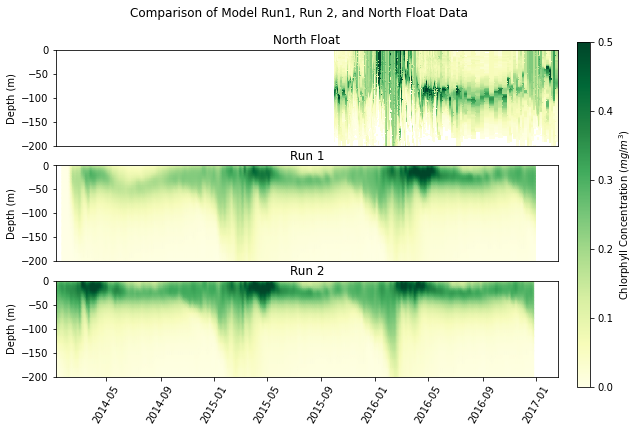

In [64]:
nDates_array = np.array(nDates)
fig = plt.figure(1, figsize=(9,6))
plt.subplot(311)
im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_chla[:,:168],cmap='YlGn', vmin = 0, vmax = .5)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('North Float')
plt.ylabel('Depth (m)')
plt.xticks([])
plt.xlim([total_time[0], nDates_array[-1]])
#plt.savefig('Chl_nfloat.png', bbox_inches='tight')
#ax.set_xlim([total_time[0], nDates_array[-1]])
plt.subplot(312)
im2 = plt.pcolormesh(r1_time[:], chla['Z'][:21],chla_da_nfr1, vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.ylabel('Depth (m)')
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Run 1')
plt.xlim([total_time[0], nDates_array[-1]])
plt.xticks([])
plt.subplot(313)
im2 = plt.pcolormesh(r2_time, chla['Z'][:21],chla_da_nfr2, vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Run 2')
plt.xlim([total_time[0], nDates_array[-1]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Chlorphyll Concentration ($mg/m^3$)')
plt.suptitle('Comparison of Model Run1, Run 2, and North Float Data')
plt.savefig('r1vr2_nf_chl.png',bbox_inches = 'tight')

In [ ]:
plt.figure(1, figsize=(8,4))
labels = ['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July']
ticks = range(0,109,6)
plt.pcolormesh(total_time, chla['Z'][:21],chla_da_nf, vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Model Chlorophyll Concentration\n vs Time Within North Float Range')
plt.savefig('model1_2_chla_timeseries_nf.png',bbox_inches = 'tight')

plt.figure(4, figsize=(8,4))
plt.pcolormesh(total_time, chla['Z'][:21], salt_da_nf, vmin=39, vmax=41, cmap = 'YlGnBu', shading = 'Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.colorbar(label = 'Salinity (psu)')
plt.title('Model Salinity vs Time Within North Float Range')
plt.savefig('model1_2_salt_timeseries_nf.png', bbox_inches = 'tight')

plt.figure(5, figsize=(8,4))
plt.pcolormesh(total_time, chla['Z'][:21], o2_da_nf_u, cmap = 'coolwarm', shading = 'Gouraud', vmin=100, vmax=220)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.title('Model Dissolved Oxygen Concentration\n vs Time Within North Float Range')
plt.savefig('model1_2_o2_timeseries_nf.png', bbox_inches = 'tight')

plt.figure(7, figsize=(8,4))
plt.pcolormesh(total_time, chla['Z'][:21], theta_da_nf, cmap = 'jet', shading = 'Gouraud',vmin=22, vmax=30)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Model Potential Temp\n vs Time Within North Float Range')
plt.savefig('model1_2_theta_timeseries_nf.png', bbox_inches = 'tight')

plt.figure(8, figsize=(10,4))
plt.plot(total_time, theta_da_nf[0,:])
plt.plot(nDates, theta_nf.data[0,:168])
plt.xticks(rotation=90)
plt.title('Surface Potentail Temperature Within North Float Range')
plt.ylim([22,31])
plt.ylabel(r'Potential Temperature ($C^\circ$)')
plt.legend(['Model', 'Float'])
plt.savefig('surface_theta_nfloat.png', bbox_inches='tight')

plt.figure(9, figsize=(10,4))
plt.plot(total_time, o2_da_nf_u[0,:])
plt.plot(nDates, nfloat_o2[0,:168])
plt.xticks(rotation=90)
plt.title('Surface Oxygen Concentration Within North Float Range')
plt.ylim([180, 210])
plt.ylabel(r'Dissolved Oxygen ($\mu mol/kg$)')
plt.legend(['Model', 'Float'])
plt.savefig('surface_o2_nfloat.png', bbox_inches='tight')

In [ ]:
plt.figure(1, figsize=(7,6))
depth = chla['Depth'][:]
depth[depth == 0] = np.float('NaN')
colors = ['lightblue', 'royalblue']
nodes = [0,1]
cmap2 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes,colors)))
plt.pcolormesh(chla['XC'][200:1200], chla['YC'][1000:], depth[1000:,200:1200], cmap = cmap2)
plt.colorbar(label='Depth (m)')
plt.scatter(nfloat_meta['Longitude'], nfloat_meta['Latitude'], c='r', s=1)
plt.scatter(central_float['LONGITUDE'], central_float['LATITUDE'], c='yellow', s=1)
plt.scatter(total_longs, total_lats, c='orange', s=1)
lgnd = plt.legend(['North Float', 'Central Float', 'Glider'])
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
y=[25.5121, 25.5121]
x=[34, 37.75]
y2=[22.0121, 22.0121]
x2=[36, 40]
plt.plot(x,y, linewidth=1.5, color='navy')
plt.plot(x2,y2,linewidth=1.5,color='navy')
plt.annotate('NRS', (37,27), color='navy', size=12)
plt.annotate('NCRS', (39.5,24), color='navy', size=12)
plt.savefig('vehicle_localtion.png', bbox_inches='tight')


plt.figure(2)
plt.pcolormesh(depth)
plt.scatter(480, 1760, c='r', s=10)
plt.scatter(420, 1660, c='yellow', s=10)

In [ ]:
nDates_array = np.array(nDates)
    
fig = plt.figure(1, figsize=(9,5))
plt.subplot(211)
im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_chla[:,:168],cmap='YlGn', vmin = 0, vmax = .5)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Chlorophyll Concentration vs Time from North Float Data')
plt.ylabel('Depth (m)')
plt.xticks([])
plt.xlim([total_time[0], nDates_array[-1]])
#plt.savefig('Chl_nfloat.png', bbox_inches='tight')
#ax.set_xlim([total_time[0], nDates_array[-1]])
plt.subplot(212)
im2 = plt.pcolormesh(total_time, chla['Z'][:21],chla_da_nf, vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Model Chlorophyll Concentration vs Time Within North Float Range')
plt.xlim([total_time[0], nDates_array[-1]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Chlorphyll Concentration ($mg/m^3$)')
plt.savefig('model1_2_chla_comp_timeseries_nf.png',bbox_inches = 'tight')


fig = plt.figure(2, figsize=(9,5))
plt.subplot(2,1,1)
im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_temp[:,:168],cmap='jet', vmin = 22, vmax = 30)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.xticks([])
plt.title('Potential Temperature vs Time from Northern Float Data')
plt.ylabel('Depth (m)')
plt.xlim([total_time[0], nDates_array[-1]])
plt.subplot(2,1,2)
#plt.savefig('Temp_nfloat.png', bbox_inches='tight')
im2 = plt.pcolormesh(total_time, chla['Z'][:21], theta_da_nf, cmap = 'jet', shading = 'Gouraud',vmin=22, vmax=30)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Model Potential Temp vs Time Within North Float Range')
plt.xlim([total_time[0], nDates_array[-1]])
plt.ylim([-200, 0])
cb_ax = fig.add_axes([.93, .1, .02, .8])
fig.colorbar(im, cax=cb_ax, label =  r'Potential Temperature ($C^\circ$)')
plt.savefig('model1_2_theta_comp_timeseries_nf.png', bbox_inches = 'tight')

fig = plt.figure(3, figsize=(9,5))
plt.subplot(2,1,1)
im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_salt[:,:168],cmap='YlGnBu', vmin = 39, vmax = 41)
plt.ylim([-200, 0])
#plt.colorbar(label = 'Salinity (PSU)')
plt.xticks([])
plt.xlim([total_time[0], nDates_array[-1]])
plt.title('Salinity vs Time from Northern Float Data')
plt.ylabel('Depth (m)')
#plt.savefig('Salt_nfloat.png', bbox_inches='tight')
plt.subplot(2,1,2)
im2 = plt.pcolormesh(total_time, chla['Z'][:21], salt_da_nf, vmin=39, vmax=41, cmap = 'YlGnBu', shading = 'Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = 'Salinity (psu)')
plt.title('Model Salinity vs Time Within North Float Range')
plt.xlim([total_time[0], nDates_array[-1]])
plt.ylim([-200, 0])
cb_ax = fig.add_axes([.93, .1, .02, .8])
fig.colorbar(im, cax=cb_ax, label = 'Salinity (psu)')
plt.savefig('model1_2_salt_comp_timeseries_nf.png', bbox_inches = 'tight')



fig = plt.figure(4, figsize=(9,5))
plt.subplot(2,1,1)
im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_o2[:,:168],cmap='coolwarm', vmin = 100, vmax = 220)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.xticks([])
plt.xlim([total_time[0], nDates_array[-1]])
plt.title('Dissolved Oxygen Concentration vs Time from Northern Float Data')
plt.ylabel('Depth (m)')
#plt.savefig('O2_nfloat.png', bbox_inches='tight')
plt.subplot(2,1,2)
plt.pcolormesh(total_time, chla['Z'][:21], o2_da_nf_u, cmap = 'coolwarm', shading = 'Gouraud', vmin=100, vmax=220)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.title('Model Dissolved Oxygen Concentration vs Time Within North Float Range')
plt.xlim([total_time[0], nDates_array[-1]])
plt.ylim([-200, 0])
cb_ax = fig.add_axes([.93, .1, .02, .8])
fig.colorbar(im, cax=cb_ax, label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.savefig('model1_2_o2_comp__timeseries_nf.png', bbox_inches = 'tight')

plt.figure(5, figsize=(10,4))
plt.plot(nDates, nfloat_o2[0,:168])
plt.xticks(rotation=90)
plt.title('Surface Oxygen Concentration from North Float')
plt.ylim([180, 210])
plt.ylabel(r'Dissolved Oxygen ($\mu mol/kg$)')
#plt.savefig('surface_o2_comp_nfloat.png', bbox_inches='tight')


plt.figure(6, figsize=(10,4))
plt.plot(nDates, theta_nf.data[0,:168])
plt.xticks(rotation=90)
plt.title('Surface Potential Temperature from North Float')
plt.ylim([22,31])
plt.ylabel(r'Potential Temperature ($C^\circ$)')
#plt.savefig('surface_theta_comp_nfloat.png', bbox_inches='tight')

In [ ]:
print(0)
chla14_da_g2 =  depth_avgs(chla_14['BLGCHL'], 0 ,20, 1250, 1375, 750, 850)
chla15_da_g2 =  depth_avgs(chla_15['BLGCHL'], 0 ,20, 1250, 1375, 750, 850)
chla16_da_g2 =  depth_avgs(chla_16['BLGCHL'], 0 ,20, 1250, 1375, 750, 850)
print(1)

salt14_da_g2 = depth_avgs(salt_14['SALT'], 0 ,20, 1250, 1400, 750, 875)
salt15_da_g2 = depth_avgs(salt_15['SALT'], 0 ,20, 1250, 1400, 750, 875)
salt16_da_g2 = depth_avgs(salt_16['SALT'], 0 ,20, 1250, 1400, 750, 875)
print(2)

o214_on_da_g2 = depth_avgs(o2_14['TRAC03'], 0 ,20, 1250, 1400, 750, 875)
o215_on_da_g2 = depth_avgs(o2_15['TRAC03'], 0 ,20, 1250, 1400, 750, 875)
o216_on_da_g2 = depth_avgs(o2_16['TRAC03'][:,:,:,:], 0 ,20, 1250, 1400, 750, 875)
print(3)

theta14_on_da_g2 = depth_avgs(theta_14['THETA'], 0 ,20, 1250, 1400, 750, 875)
theta15_on_da_g2 = depth_avgs(theta_15['THETA'], 0 ,20, 1250, 1400, 750, 875)
theta16_on_da_g2 = depth_avgs(theta_16['THETA'], 0 ,20, 1250, 1400, 750, 875)

chla_da_g2 = np.concatenate([chla14_da_g2, chla15_da_g2, chla16_da_g2],axis=1)
salt_da_g2 = np.concatenate([salt14_da_g2, salt15_da_g2, salt16_da_g2],axis=1)
o2_on_da_g2 = np.concatenate([o214_on_da_g2, o215_on_da_g2, o216_on_da_g2],axis=1)
theta_on_da_g2 = np.concatenate([theta14_on_da_g2, theta15_on_da_g2, theta16_on_da_g2],axis=1)

o2_on_da_g2_u = (o2_on_da_g2*1000000)/1028

In [ ]:
print(0)
chla14_da_g2 =  depth_avgs(chla_14['BLGCHL'], 0 ,20, 1250, 1375, 750, 850)
print(1)
chla15_da_g2 =  depth_avgs(chla_15['BLGCHL'], 0 ,20, 1250, 1375, 750, 850)
print(1)
chla16_da_g2 =  depth_avgs(chla_16['BLGCHL'], 0 ,20, 1250, 1375, 750, 850)
print(1)
chla_da_g2 = np.concatenate([chla14_da_g2, chla15_da_g2, chla16_da_g2],axis=1)


In [ ]:
im2 = plt.pcolormesh(total_time, chla['Z'][:21],chla_da_g2, vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')


In [ ]:
fig = plt.figure(1, figsize=(9,5))
plt.subplot(2,1,1)
im1= plt.pcolormesh(g2_tt, -1*g2_prt, g2_chlt,cmap='YlGn', vmin = 0, vmax = .5)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Chlorophyll Concentration vs Time from Central Glider Data')
plt.ylabel('Depth (m)')
plt.xticks([])
plt.xlim([total_time[30], total_time[-100]])
ax = plt.gca()
rect = Rectangle((g2_tt[290], 0), g2_tt[310]-g2_tt[290], -200, color='white', fill=True)
ax.add_patch(rect)
#plt.savefig('Chl_nfloat.png', bbox_inches='tight')
#ax.set_xlim([total_time[0], nDates_array[-1]])
plt.subplot(212)
im2 = plt.pcolormesh(total_time, chla['Z'][:21],chla_da_g2, vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Model Chlorophyll Concentration vs Time Cenral GLider Float Range')
plt.xlim([total_time[30], total_time[-100]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im1, cax=cb_ax, label =  r'Chlorphyll Concentration ($mg/m^3$)')
plt.savefig('model1_2_chla_comp_timeseries_g2.png',bbox_inches = 'tight')

In [ ]:
def converted_datenum(times):
    new_times = []
    for i in range(len(times)):
        try:
            new_times.append(datetime.fromordinal(int(times[i])-366) + timedelta(days=times[i]%1))
        except ValueError:
            new_times.append(np.float('NaN'))
    return(new_times)
glider2 = loadmat('glider2.mat')
g2_t1 = converted_datenum(np.nanmean(glider2['Ztime250_tr1'], 0))
g2_t2 = np.flip(converted_datenum(np.nanmean(glider2['Ztime250_tr2'], 0)))
g2_t4 = np.flip(converted_datenum(np.nanmean(glider2['Ztime250_tr4'], 0)))
g2_chl1 = glider2['Zchl250factor_tr1']
g2_chl2 = np.flip(glider2['Zchl250factor_tr2'],1)
g2_chl4 = np.flip(glider2['Zchl250factor_tr4'],1)
g2_T1 = glider2['ZT250_tr1']
g2_T2 = np.flip(glider2['ZT250_tr2'],1)
g2_T4 = np.flip(glider2['ZT250_tr4'],1)
g2_S1 = glider2['ZS250_tr1']
g2_S2 = np.flip(glider2['ZS250_tr2'],1)
g2_S4 = np.flip(glider2['ZS250_tr4'],1)
g2_O21 = glider2['ZO2_250_tr1']
g2_O22 = np.flip(glider2['ZO2_250_tr2'],1)
g2_O24 = np.flip(glider2['ZO2_250_tr4'],1)
g2_pr1 = np.nanmean(glider2['ZPR250_tr1'],1)
g2_pr2 = np.nanmean(glider2['ZPR250_tr2'],1)
g2_pr4 = np.nanmean(glider2['ZPR250_tr4'],1)
g2_chlt = np.concatenate((np.concatenate((g2_chl1, g2_chl2, g2_chl4), 1)[:-44,8:155], np.concatenate((g2_chl1, g2_chl2, g2_chl4), 1)[:-44, 166:310], np.concatenate((g2_chl1, g2_chl2, g2_chl4), 1)[:-44, 330:481]),1)
g2_Tt = np.concatenate((np.concatenate((g2_T1, g2_T2, g2_T4), 1)[:-44,8:155], np.concatenate((g2_T1, g2_T2, g2_T4), 1)[:-44, 166:310], np.concatenate((g2_T1, g2_T2, g2_T4), 1)[:-44, 330:481]),1)
g2_St = np.concatenate((np.concatenate((g2_S1, g2_S2, g2_S4), 1)[:-44,8:155], np.concatenate((g2_S1, g2_S2, g2_S4), 1)[:-44, 166:310], np.concatenate((g2_S1, g2_S2, g2_S4), 1)[:-44, 330:481]),1)
g2_O2t = np.concatenate((np.concatenate((g2_O21, g2_O22, g2_O24), 1)[:-44,8:155], np.concatenate((g2_O21, g2_O22, g2_O24), 1)[:-44, 166:310], np.concatenate((g2_O21, g2_O22, g2_O24), 1)[:-44, 330:481]),1)
g2_prt = g2_pr4[:-44]
g2_prt[0] = 0
g2_prte = np.rot90(np.tile(g2_prt, (442,1)), 3)
g2_tt = np.concatenate((np.concatenate((g2_t1, g2_t2, g2_t4))[8:155], np.concatenate((g2_t1, g2_t2, g2_t4))[166:310], np.concatenate((g2_t1, g2_t2, g2_t4))[330:481]))
g2_theta = sw.eos80.ptmp(g2_St, g2_Tt, g2_prte, 0)
print(g2_tt)

In [ ]:
x = np.array([1,2,3,4])
print(np.shape(x))
x = np.rot90(np.tile(x, (422,1)))
print(np.shape(x))
#print(np.repeat(x, 2, axis = 1))

In [ ]:
g2_weighted = chla_da_g2
temp = 0
g2_msum = []
for i in range(218):
    temp = g2_weighted[:20,i] * chla['drF'][:20]
    g2_msum.append(np.sum(temp))
#print(np.shape(nfloat_chla[:213,:168]))
g2_isum = []
temp = 0
for i in range(len(g2_tt)):
    temp = np.nansum(g2_chlt[:, i])
    g2_isum.append(temp)

In [ ]:

    
fig = plt.figure(1, figsize=(9,5))
plt.subplot(2,1,1)
im1= plt.pcolormesh(g2_tt, -1*g2_prt, g2_chlt,cmap='YlGn', vmin = 0, vmax = .5)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Chlorophyll Concentration vs Time from Central Glider Data')
plt.ylabel('Depth (m)')
plt.xticks([])
plt.xlim([total_time[30], total_time[-100]])
ax = plt.gca()
rect = Rectangle((g2_tt[290], 0), g2_tt[310]-g2_tt[290], -200, color='white', fill=True)
ax.add_patch(rect)
#plt.savefig('Chl_nfloat.png', bbox_inches='tight')
#ax.set_xlim([total_time[0], nDates_array[-1]])
plt.subplot(212)
im2 = plt.pcolormesh(total_time, chla['Z'][:21],chla_da_g2, vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Model Chlorophyll Concentration vs Time Cenral GLider Float Range')
plt.xlim([total_time[30], total_time[-100]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im1, cax=cb_ax, label =  r'Chlorphyll Concentration ($mg/m^3$)')
plt.savefig('model1_2_chla_comp_timeseries_g2.png',bbox_inches = 'tight')


fig = plt.figure(2, figsize=(9,5))
plt.subplot(2,1,1)
im = plt.pcolormesh(g2_tt, -1*g2_prt, g2_theta,cmap='jet', vmin = 22, vmax = 30)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.xticks([])
plt.title('Potential Temperature vs Time from Central Glider Data')
plt.ylabel('Depth (m)')
plt.xlim([total_time[30], total_time[-100]])
ax = plt.gca()
rect = Rectangle((g2_tt[290], 0), g2_tt[310]-g2_tt[290], -200, color='white', fill=True)
ax.add_patch(rect)
plt.subplot(2,1,2)
#plt.savefig('Temp_nfloat.png', bbox_inches='tight')
im2 = plt.pcolormesh(total_time, chla['Z'][:21], theta_on_da_g2, cmap = 'jet', shading = 'Gouraud',vmin=22, vmax=30)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Model Potential Temp vs Time Within Central Glider Range')
plt.xlim([total_time[30], total_time[-100]])
plt.ylim([-200, 0])
cb_ax = fig.add_axes([.93, .1, .02, .8])
fig.colorbar(im, cax=cb_ax, label =  r'Potential Temperature ($C^\circ$)')
plt.savefig('model1_2_theta_comp_timeseries_g2.png', bbox_inches = 'tight')

fig = plt.figure(3, figsize=(9,5))
plt.subplot(2,1,1)
im = plt.pcolormesh(g2_tt, -1*g2_prt, g2_St ,cmap='YlGnBu', vmin = 39, vmax = 41)
plt.ylim([-200, 0])
#plt.colorbar(label = 'Salinity (PSU)')
plt.xticks([])
plt.xlim([total_time[30], total_time[-100]])
ax = plt.gca()
rect = Rectangle((g2_tt[290], 0), g2_tt[310]-g2_tt[290], -200, color='white', fill=True)
ax.add_patch(rect)
plt.title('Salinity vs Time from Central Glider Data')
plt.ylabel('Depth (m)')
#plt.savefig('Salt_nfloat.png', bbox_inches='tight')
plt.subplot(2,1,2)
im2 = plt.pcolormesh(total_time, chla['Z'][:21], salt_da_g2, vmin=39, vmax=41, cmap = 'YlGnBu', shading = 'Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = 'Salinity (psu)')
plt.title('Model Salinity vs Time Within Central Glider Range')
plt.xlim([total_time[30], total_time[-100]])
plt.ylim([-200, 0])
cb_ax = fig.add_axes([.93, .1, .02, .8])
fig.colorbar(im, cax=cb_ax, label = 'Salinity (psu)')
plt.savefig('model1_2_salt_comp_timeseries_g2.png', bbox_inches = 'tight')



fig = plt.figure(4, figsize=(9,5))
plt.subplot(2,1,1)
im = plt.pcolormesh(g2_tt, -1*g2_prt, g2_O2t,cmap='coolwarm', vmin = 100, vmax = 220)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.xticks([])
plt.xlim([total_time[30], total_time[-100]])
ax = plt.gca()
rect = Rectangle((g2_tt[290], 0), g2_tt[310]-g2_tt[290], -200, color='white', fill=True)
ax.add_patch(rect)
plt.title('Dissolved Oxygen Concentration vs Time from Central Glider Data')
plt.ylabel('Depth (m)')
#plt.savefig('O2_nfloat.png', bbox_inches='tight')
plt.subplot(2,1,2)
plt.pcolormesh(total_time, chla['Z'][:21], o2_on_da_g2_u, cmap = 'coolwarm', shading = 'Gouraud', vmin=100, vmax=220)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.title('Model Dissolved Oxygen Concentration vs Time Within Central Glider Range')
plt.xlim([total_time[30], total_time[-100]])
plt.ylim([-200, 0])
cb_ax = fig.add_axes([.93, .1, .02, .8])
fig.colorbar(im, cax=cb_ax, label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.savefig('model1_2_o2_comp__timeseries_g2.png', bbox_inches = 'tight')

plt.figure(8, figsize=(10,4))
plt.plot(total_time, theta_on_da_g2[0,:])
plt.plot(g2_tt, g2_theta[0,:])
plt.xticks(rotation=90)
plt.title('Surface Potentail Temperature Within Central Glider Range')
plt.ylim([22,31])
plt.xlim([total_time[30], total_time[-100]])
plt.ylabel(r'Potential Temperature ($C^\circ$)')
plt.legend(['Model', 'Glider'])
plt.savefig('surface_theta_g2t.png', bbox_inches='tight')

plt.figure(9, figsize=(10,4))
plt.plot(total_time, o2_on_da_g2_u[0,:])
plt.plot(g2_tt, g2_O2t[0,:])
plt.xticks(rotation=90)
plt.title('Surface Oxygen Concentration Within Central Glider Range')
plt.ylim([180, 210])
plt.xlim([total_time[30], total_time[-100]])
plt.ylabel(r'Dissolved Oxygen ($\mu mol/kg$)')
plt.legend(['Model', 'Glider'])
plt.savefig('surface_o2_g2.png', bbox_inches='tight')

plt.figure(10, figsize=(10, 4))
plt.plot(total_time, g2_msum)
plt.plot(g2_tt, g2_isum, alpha=.75)
plt.legend(['Model', 'Float'])
plt.xticks(rotation=60)
plt.xlim([total_time[30], total_time[-100]])
plt.ylabel(r'Detph Integrated Chlorphyll Concentration ($mg/m^2$)')
plt.title('Glider')
plt.savefig('figures/g2_di_chl.png', bbox_inches='tight')

In [37]:
cdates = []
for i in range(58):
     cdates.append(central_float.DATE[i*1000])


for i in range(58):
    cdates[i] = pd.to_datetime(cdates[i], format='%m/%d/%Y')
print(cdates)

[Timestamp('2015-10-03 00:00:00'), Timestamp('2015-10-04 00:00:00'), Timestamp('2015-10-05 00:00:00'), Timestamp('2015-10-06 00:00:00'), Timestamp('2015-10-07 00:00:00'), Timestamp('2015-10-08 00:00:00'), Timestamp('2015-10-09 00:00:00'), Timestamp('2015-10-10 00:00:00'), Timestamp('2015-10-15 00:00:00'), Timestamp('2015-10-20 00:00:00'), Timestamp('2015-10-25 00:00:00'), Timestamp('2015-10-30 00:00:00'), Timestamp('2015-11-04 00:00:00'), Timestamp('2015-11-09 00:00:00'), Timestamp('2015-11-14 00:00:00'), Timestamp('2015-11-19 00:00:00'), Timestamp('2015-11-24 00:00:00'), Timestamp('2015-11-29 00:00:00'), Timestamp('2015-12-04 00:00:00'), Timestamp('2015-12-09 00:00:00'), Timestamp('2015-12-11 00:00:00'), Timestamp('2015-12-13 00:00:00'), Timestamp('2015-12-15 00:00:00'), Timestamp('2015-12-17 00:00:00'), Timestamp('2015-12-19 00:00:00'), Timestamp('2015-12-21 00:00:00'), Timestamp('2015-12-23 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2015-12-27 00:00:00'), Timestamp('20

In [32]:
cfloat_theta = sw.eos80.ptmp(central_float.SALINITY, central_float.TEMPERATURE, central_float.PRES, 0)

In [ ]:
plt.figure(1, figsize=(8,4))
chl = np.array(central_float.CHLA_CALIBRATED)
chl = np.reshape(chl, (1000,58), order='F')
plt.pcolormesh(cdates,-avg.PRES, chl, cmap='YlGn', vmin = 0, vmax = .5)
plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.ylim([-350, 0])
plt.xticks(rotation = 90)
plt.title('Chlorophyll Concentration\n vs Time from Central Float Data')
plt.ylabel('Depth (m)')
plt.savefig('Chl_float.png', bbox_inches='tight')


plt.figure(2, figsize=(8,4))
o2 = np.array(central_float.OXYGEN)
o2 = np.reshape( o2, (1000,58), order='F')
plt.pcolormesh(cdates,-avg.PRES, o2, cmap='coolwarm',vmin=50, vmax=210)
plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.ylim([-250, 0])
ticks = []
labels = []
for i in range(0,58, 5):
    ticks.append(cdates[i])
plt.xticks(rotation = 30)
plt.title('Dissolved Oxygen Concentration\n vs Time from Central Float Data')
plt.ylabel('Depth (m)')
plt.savefig('O2_float.png', bbox_inches='tight')

plt.figure(3, figsize=(8,4))
tem = np.array(cfloat_theta)
tem = np.reshape( tem, (1000,58), order='F')
plt.pcolormesh(cdates,-avg.PRES, tem, cmap='jet', vmin=22, vmax=30)
plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.ylim([-250, 0])
ticks = []
labels
for i in range(0,58, 5):
    ticks.append(cdates[i])
plt.xticks(rotation = 30)
plt.title('Potential Temperature\n vs Time from Central Float Data')
plt.ylabel('Depth (m)')
plt.savefig('Temp_float.png', bbox_inches='tight')

plt.figure(4, figsize=(8,4))
sal = np.array(central_float.SALINITY)
sal = np.reshape(sal, (1000,58), order='F')
plt.pcolormesh(cdates,-avg.PRES, sal, cmap='YlGnBu', vmin=39, vmax=41)
plt.colorbar(label = 'Salinity (PSU)')
plt.ylim([-250, 0])
ticks = []
labels = []
for i in range(0,58, 5):
    ticks.append(cdates[i])
plt.xticks(rotation = 30)
plt.title('Salinity\n vs Time from Central Float Data')
plt.ylabel('Depth (m)')
plt.savefig('Salt_float.png', bbox_inches='tight')

plt.figure(5, figsize=(10,4))
plt.plot(cdates, tem[0,:])
plt.xticks(rotation=90)
plt.ylim([22,32])
plt.ylabel(r'Potential Temperature ($C^\circ$)')
plt.title('Surface Potential Temperature from Central Float')
plt.savefig('surface_theta_cfloat.png', bbox_inches='tight')

plt.figure(6, figsize=(10,4))
plt.plot(cdates, o2[0,:])
plt.xticks(rotation=90)
plt.ylim([180, 220])
plt.ylabel(r'Dissolved Oxygen ($\mu mol/kg$)')
plt.title('Surface Oxygen Concentration from Central Float')
plt.savefig('surface_o2_cfloat.png', bbox_inches='tight')

In [ ]:
print(0)
chla14_da_f =  depth_avgs(chla_14['BLGCHL'], 0 ,20, 1425, 1475, 625, 675)
chla15_da_f =  depth_avgs(chla_15['BLGCHL'], 0 ,20, 1425, 1475, 625, 675)
chla16_da_f =  depth_avgs(chla_16['BLGCHL'], 0 ,20, 1425, 1475, 625, 675)
print(1)

salt14_da_f = depth_avgs(salt_14['SALT'], 0 ,20, 1425, 1475, 625, 675)
salt15_da_f = depth_avgs(salt_15['SALT'], 0 ,20, 1425, 1475, 625, 675)
salt16_da_f = depth_avgs(salt_16['SALT'], 0 ,20, 1425, 1475, 625, 675)
print(2)

o214_on_da_f = depth_avgs(o2_14['TRAC03'], 0 ,20, 1425, 1475, 625, 675)
o215_on_da_f = depth_avgs(o2_15['TRAC03'], 0 ,20, 1425, 1475, 625, 675)
o216_on_da_f = depth_avgs(o2_16['TRAC03'][:,:,:,:], 0 ,20, 1425, 1475, 625, 675)
print(3)

theta14_on_da_f = depth_avgs(theta_14['THETA'], 0 ,20, 1425, 1475, 625, 675)
theta15_on_da_f = depth_avgs(theta_15['THETA'], 0 ,20, 1425, 1475, 625, 675)
theta16_on_da_f = depth_avgs(theta_16['THETA'], 0 ,20, 1425, 1475, 625, 675)

chla_da_f = np.concatenate([chla14_da_f, chla15_da_f, chla16_da_f],axis=1)
salt_da_f = np.concatenate([salt14_da_f, salt15_da_f, salt16_da_f],axis=1)
o2_on_da_f = np.concatenate([o214_on_da_f, o215_on_da_f, o216_on_da_f],axis=1)
theta_on_da_f = np.concatenate([theta14_on_da_f, theta15_on_da_f, theta16_on_da_f],axis=1)

o2_on_da_f_u = (o2_on_da_f*1000000)/1028

In [33]:
salt_da_f = depth_avgs(salt_14['SALT'], 0 ,49, 1425, 1475, 625, 675)
theta_on_da_f = depth_avgs(theta_14['THETA'], 0 ,49, 1425, 1475, 625, 675)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


<ipython-input-107-f35a6d3fdb8a>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  fig2 = plt.pcolormesh(cdates,-avg.PRES, sal, cmap='YlGnBu', vmin=40.15, vmax=40.65)
<ipython-input-107-f35a6d3fdb8a>:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = plt.pcolormesh(cdates,-avg.PRES, tem, cmap='jet', vmin=22, vmax=25)


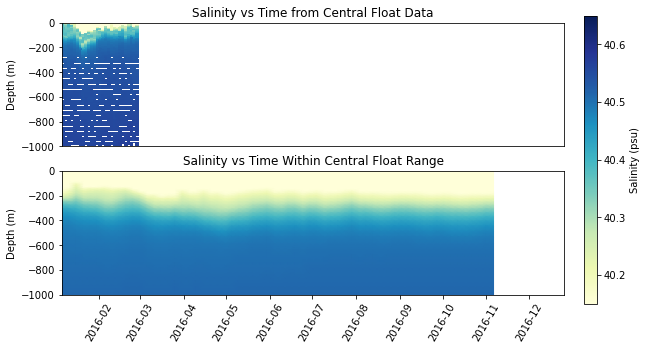

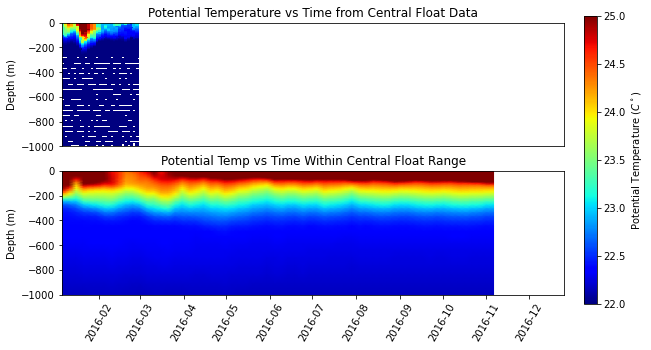

In [107]:
fig = plt.figure(2, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(no3['time'][:62], no3['Z'][:], salt_da_f, vmin=40.15, vmax=40.65, cmap = 'YlGnBu', shading = 'Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = 'Salinity (psu)')
plt.xlim([no3['time'][0], no3['time'][-1]])
plt.title('Salinity vs Time Within Central Float Range')
plt.ylim([-1000,0])
#plt.savefig('model1_2_salt_timeseries_f.png', bbox_inches = 'tight')
plt.subplot(2,1,1)
sal = np.array(central_float.SALINITY)
sal = np.reshape(sal, (1000,58), order='F')
fig2 = plt.pcolormesh(cdates,-avg.PRES, sal, cmap='YlGnBu', vmin=40.15, vmax=40.65)
#plt.colorbar(label = 'Salinity (PSU)')
plt.ylim([-1000, 0])
plt.xticks([])
plt.title('Salinity vs Time from Central Float Data')
plt.ylabel('Depth (m)')
plt.xlim([no3['time'][0], no3['time'][-1]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  'Salinity (psu)')
plt.savefig('Saltstrat_cf.png', bbox_inches='tight')

fig = plt.figure(4, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(no3['time'][:62], no3['Z'][:], theta_on_da_f, cmap = 'jet', shading = 'Gouraud',vmin=22, vmax=25)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Potential Temp vs Time Within Central Float Range')
#plt.savefig('model1_2_theta_timeseries_f.png', bbox_inches = 'tight')
plt.ylim([-1000,0])
plt.xlim([no3['time'][0], no3['time'][-1]])
plt.subplot(2,1,1)
tem = np.array(cfloat_theta)
tem = np.reshape( tem, (1000,58), order='F')
im2 = plt.pcolormesh(cdates,-avg.PRES, tem, cmap='jet', vmin=22, vmax=25)
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.ylim([-1000, 0])
plt.xlim([no3['time'][0], no3['time'][-1]])
plt.xticks([])
plt.title('Potential Temperature vs Time from Central Float Data')
plt.ylabel('Depth (m)')
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Potential Temperature ($C^\circ$)')
plt.savefig('Tempstrat_cf.png', bbox_inches='tight')


In [ ]:
chla14_da =  model.depth_avgs(chla_14['BLGCHL'], 0 ,20, 1700, 1740, 500, 560)
chla15_da =  model.depth_avgs(chla_15['BLGCHL'], 0 ,20, 1700, 1740, 500, 560)
print(1/6)
salt14_da = model.depth_avgs(salt_14['SALT'], 0 ,20, 1700, 1740, 500, 560)
salt15_da = model.depth_avgs(salt_15['SALT'], 0 ,20, 1700, 1740, 500, 560)
print(2/6)
o214_off_da = model.depth_avgs(o2_14['TRAC03'], 0 ,20, 1700, 1740, 500, 510)
o215_off_da = model.depth_avgs(o2_15['TRAC03'], 0 ,20, 1700, 1740, 500, 510)
print(3/6)
o214_on_da = model.depth_avgs(o2_14['TRAC03'], 0 ,20, 1700, 1740, 550, 560)
o215_on_da = model.depth_avgs(o2_15['TRAC03'], 0 ,20, 1700, 1740, 550, 560)
print(4/6)
theta14_off_da = model.depth_avgs(theta_14['THETA'], 0 ,20, 1700, 1740, 500, 510)
theta15_off_da = depth_avgs(theta_15['THETA'], 0 ,20, 1700, 1740, 500, 510)
print(1/9)
theta14_on_da = depth_avgs(theta_14['THETA'], 0 ,20, 1700, 1740, 550, 560)
print(2/9)
theta15_on_da = depth_avgs(theta_15['THETA'], 0 ,20, 1700, 1740, 550, 560)
print(3/9)
chla16_da =  depth_avgs(chla_16['BLGCHL'], 0 ,20, 1700, 1740, 500, 560)
print(4/9)
salt16_da = depth_avgs(salt_16['SALT'], 0 ,20, 1700, 1740, 500, 560)
print(5/9)
o216_off_da = depth_avgs(o2_16['TRAC03'], 0 ,20, 1700, 1740, 500, 510)
print(6/9)
o216_on_da = depth_avgs(o2_16['TRAC03'], 0 ,20, 1700, 1740, 550, 560)
print(7/9)
theta16_off_da = depth_avgs(theta_16['THETA'], 0 ,20, 1700, 1740, 500, 510)
print(8/9)
theta16_on_da = depth_avgs(theta_16['THETA'], 0 ,20, 1700, 1740, 550, 560)

In [ ]:
chla_da = np.concatenate([chla14_da, chla15_da, chla16_da],axis=1)
salt_da = np.concatenate([salt14_da, salt15_da, salt16_da],axis=1)
o2_off_da = np.concatenate([o214_off_da, o215_off_da, o216_off_da],axis=1)
o2_on_da = np.concatenate([o214_on_da, o215_on_da, o216_on_da],axis=1)
theta_off_da = np.concatenate([theta14_off_da, theta15_off_da, theta16_off_da],axis=1)
theta_on_da = np.concatenate([theta14_on_da, theta15_on_da, theta16_on_da],axis=1)

In [ ]:
cfloat_weighted = chla_da_f
temp = 0
cfloat_msum = []
for i in range(216):
    temp = cfloat_weighted[:20,i] * chla['drF'][:20]
    cfloat_msum.append(np.sum(temp))
print(np.shape(chl))
cfloat_isum = []
temp = 0
for i in range(58):
    temp = np.nansum(chl[:213, i])
    temp = temp/(np.count_nonzero(~np.isnan(chl[:213,i])))
    temp = temp * 213.5
    cfloat_isum.append(temp)

In [ ]:
#plt.plot(total_time, cfloat_msum)
#plt.plot(cdates, cfloat_isum, alpha=.75)
#plt.legend(['Model', 'Float'])
#plt.xticks(rotation=60)
#plt.ylabel(r'Depth Integrated Chlorphyll Concentration ($mg/m^2$)')
#plt.title('Central Float')
#plt.savefig('figures/cf_di_chl.png', bbox_inches='tight')

In [ ]:
fig = plt.figure(1, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(total_time, chla['Z'][:21],chla_da_f, vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Chlorophyll Concentration vs Time Within Central Float Range')
#plt.savefig('model1_2_chla_timeseries_f.png',bbox_inches = 'tight')
plt.xlim([total_time[0], total_time[-1]])
chl = np.array(central_float.CHLA_CALIBRATED)
chl = np.reshape(chl, (1000,58), order='F')
plt.ylim([-250, 0])
plt.subplot(2,1,1)
im2 = plt.pcolormesh(cdates,-avg.PRES, chl, cmap='YlGn', vmin = 0, vmax = .5)
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.ylim([-350, 0])
plt.xticks([])
plt.title('Chlorophyll Concentration vs Time from Central Float Data')
plt.ylabel('Depth (m)')
plt.xlim([total_time[0], total_time[-1]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Chlorphyll Concentration ($mg/m^3$)')
plt.savefig('Chl_float.png', bbox_inches='tight')

fig = plt.figure(2, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(total_time, chla['Z'][:21], salt_da_f, vmin=39, vmax=41, cmap = 'YlGnBu', shading = 'Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = 'Salinity (psu)')
plt.xlim([total_time[0], total_time[-1]])
plt.title('Salinity vs Time Within Central Float Range')
plt.ylim([-250,0])
#plt.savefig('model1_2_salt_timeseries_f.png', bbox_inches = 'tight')
plt.subplot(2,1,1)
sal = np.array(central_float.SALINITY)
sal = np.reshape(sal, (1000,58), order='F')
fig2 = plt.pcolormesh(cdates,-avg.PRES, sal, cmap='YlGnBu', vmin=39, vmax=41)
#plt.colorbar(label = 'Salinity (PSU)')
plt.ylim([-250, 0])
plt.xticks([])
plt.title('Salinity vs Time from Central Float Data')
plt.ylabel('Depth (m)')
plt.xlim([total_time[0], total_time[-1]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  'Salinity (psu)')
plt.savefig('Salt_float.png', bbox_inches='tight')

fig = plt.figure(3, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(total_time, chla['Z'][:21], o2_on_da_f_u, cmap = 'coolwarm', shading = 'Gouraud', vmin=100, vmax=220)
plt.xticks(rotation=60)
plt.ylim([-250, 0])
plt.ylabel('Depth (m)')
plt.xlim([total_time[0], total_time[-1]])
#plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.title('Dissolved Oxygen Concentration vs Time Within Central Float Range')
#plt.savefig('model1_2_o2_timeseries_f.png', bbox_inches = 'tight')
plt.subplot(2,1,1)
o2 = np.array(central_float.OXYGEN)
o2 = np.reshape( o2, (1000,58), order='F')
im2 = plt.pcolormesh(cdates,-avg.PRES, o2, cmap='coolwarm',vmin=50, vmax=210)
#plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.ylim([-250, 0])
plt.xlim([total_time[0], total_time[-1]])
plt.xticks([])
plt.title('Dissolved Oxygen Concentration vs Time from Central Float Data')
plt.ylabel('Depth (m)')
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Dissolved Oxygen ($\mu mol/kg$)')
plt.savefig('O2_float.png', bbox_inches='tight')


fig = plt.figure(4, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(total_time, chla['Z'][:21], theta_on_da_f, cmap = 'jet', shading = 'Gouraud',vmin=22, vmax=30)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Potential Temp vs Time Within Central Float Range')
#plt.savefig('model1_2_theta_timeseries_f.png', bbox_inches = 'tight')
plt.ylim([-250,0])
plt.xlim([total_time[0], total_time[-1]])
plt.subplot(2,1,1)
tem = np.array(cfloat_theta)
tem = np.reshape( tem, (1000,58), order='F')
im2 = plt.pcolormesh(cdates,-avg.PRES, tem, cmap='jet', vmin=22, vmax=30)
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.ylim([-250, 0])
plt.xlim([total_time[0], total_time[-1]])
plt.xticks([])
plt.title('Potential Temperature vs Time from Central Float Data')
plt.ylabel('Depth (m)')
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Potential Temperature ($C^\circ$)')
plt.savefig('Temp_float.png', bbox_inches='tight')

plt.figure(5, figsize=(10,4))
plt.plot(total_time, theta_on_da_f[0,:])
plt.plot(cdates, tem[0,:])
plt.xticks(rotation=60)
plt.title('Surface Potential Temperature within Central Float Range')
plt.legend(['Model', 'Float'])
plt.ylabel(r'Potential Temperature ($C^\circ$)')
plt.ylim([22,32])
plt.savefig('surface_theta_cfloat.png', bbox_inches='tight')

plt.figure(6, figsize=(10,4))
plt.plot(total_time, o2_on_da_f_u[0,:])
plt.plot(cdates, o2[0,:])
plt.xticks(rotation=60)
plt.title('Surface Oxygen Cocentration within Central Float Range')
plt.ylabel(r'Dissolved Oxygen ($\mu mol/kg$)')
plt.legend(['Model', 'Float'])
plt.ylim([180, 220])
plt.savefig('surface_o2_cfloat.png', bbox_inches='tight')

In [64]:
salt_da = model.depth_avgs(salt_14['SALT'], 0 ,36, 1700, 1740, 500, 560)
theta_da = model.depth_avgs(theta_14['THETA'], 0 ,36, 1700, 1740, 500, 560)

In [ ]:
[:353], depth_g[:,0], chla_g[:112,:353], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im3 = plt.pcolormesh(total_times[353:903], depth_g[:,0], chla_g[:112,353:903], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im4 = plt.pcolormesh(total_times[903:]

In [89]:
print(np.shape(total_theta[:,:353]), np.shape(total_times[:353]), np.shape(total_depth))

(451, 353) (353,) (451, 1173)


<ipython-input-96-843e61601c30>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = plt.pcolormesh(total_times[:353],total_depth[:,:353], total_theta[:,:353], cmap='jet', vmin=22, vmax=25)
<ipython-input-96-843e61601c30>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = plt.pcolormesh(total_times[353:903],total_depth[:,353:903], total_theta[:,353:903], cmap='jet', vmin=22, vmax=25)
<ipython-input-96-843e61601c30>:16: MatplotlibDeprecationWarning: s

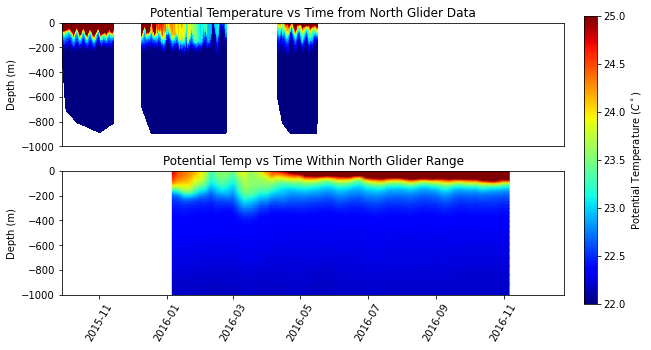

In [96]:
fig = plt.figure(4, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(no3['time'][:62], no3['Z'][:37], theta_da, cmap = 'jet', shading = 'Gouraud',vmin=22, vmax=25)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Potential Temp vs Time Within North Glider Range')
#plt.savefig('model1_2_theta_timeseries_f.png', bbox_inches = 'tight')
plt.ylim([-1000,0])
plt.xlim([total_times[0], no3['time'][-1]])
plt.subplot(2,1,1)
tem = np.array(cfloat_theta)
tem = np.reshape( tem, (1000,58), order='F')
im2 = plt.pcolormesh(total_times[:353],total_depth[:,:353], total_theta[:,:353], cmap='jet', vmin=22, vmax=25)
im2 = plt.pcolormesh(total_times[353:903],total_depth[:,353:903], total_theta[:,353:903], cmap='jet', vmin=22, vmax=25)
im2 = plt.pcolormesh(total_times[903:],total_depth[:,903:], total_theta[:,903:], cmap='jet', vmin=22, vmax=25)

#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.ylim([-1000, 0])
plt.xlim([total_times[0], no3['time'][-1]])
plt.xticks([])
plt.title('Potential Temperature vs Time from North Glider Data')
plt.ylabel('Depth (m)')
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Potential Temperature ($C^\circ$)')
plt.savefig('Temp_ng_strat.png', bbox_inches='tight')




<ipython-input-97-ff0d0631f27b>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im3 = plt.pcolormesh(total_times[:353],total_depth[:,:353], total_salinity[:,:353], cmap='YlGnBu', vmin=40.15, vmax=40.65)
<ipython-input-97-ff0d0631f27b>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im4 = plt.pcolormesh(total_times[353:903],total_depth[:,353:903], total_salinity[:,353:903], cmap='YlGnBu', vmin=40.15, vmax=40.65)
<ipython-input-97-ff0d0631f27b>:16: Matplot

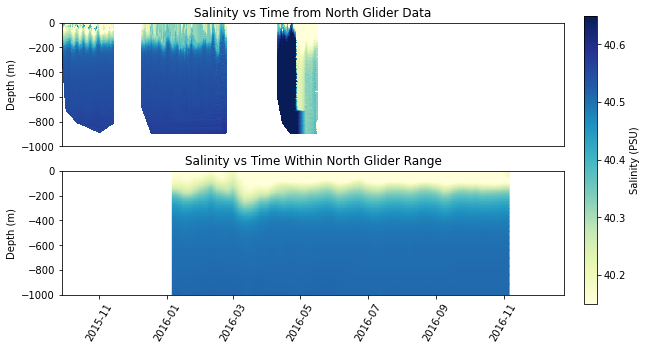

In [97]:
fig2 = plt.figure(4, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(no3['time'][:62], no3['Z'][:37], salt_da, cmap = 'YlGnBu', shading = 'Gouraud',vmin=40.15, vmax=40.65)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Salinity vs Time Within North Glider Range')
#plt.savefig('model1_2_theta_timeseries_f.png', bbox_inches = 'tight')
plt.ylim([-1000,0])
plt.xlim([total_times[0], no3['time'][-1]])
plt.subplot(2,1,1)
tem = np.array(cfloat_theta)
tem = np.reshape( tem, (1000,58), order='F')
im3 = plt.pcolormesh(total_times[:353],total_depth[:,:353], total_salinity[:,:353], cmap='YlGnBu', vmin=40.15, vmax=40.65)
im4 = plt.pcolormesh(total_times[353:903],total_depth[:,353:903], total_salinity[:,353:903], cmap='YlGnBu', vmin=40.15, vmax=40.65)
im5 = plt.pcolormesh(total_times[903:],total_depth[:,903:], total_salinity[:,903:], cmap='YlGnBu', vmin=40.15, vmax=40.65)

#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.ylim([-1000, 0])
plt.xlim([total_times[0], no3['time'][-1]])
plt.xticks([])
plt.title('Salinity vs Time from North Glider Data')
plt.ylabel('Depth (m)')
cb_ax = fig2.add_axes([.93, .1,.02,.8])
fig2.colorbar(im3, cax=cb_ax, label =  'Salinity (PSU)')
plt.savefig('Salt_ng_strat.png', bbox_inches='tight')

In [ ]:
#o2_da_u = (o2_da*1000000)/1140
o2_on_da_u = (o2_on_da*1000000)/1028
o2_off_da_u = (o2_off_da*1000000)/1028

In [45]:
shore_o2_g = np.loadtxt('shore_o2.csv', delimiter=',')
offshore_o2_g = np.loadtxt('offshore_o2.csv', delimiter=',')
shore_theta_g = np.loadtxt('shore_theta.csv', delimiter=',')
offshore_theta_g = np.loadtxt('offshore_theta.csv', delimiter=',')
salt_g = np.loadtxt('glider_salt.csv', delimiter=',')
depth_g = np.loadtxt('glider_depth.csv', delimiter=',')
chla_g = np.loadtxt('glider_chla.csv', delimiter=',')
offshore_time_g = np.loadtxt('converted_offshore_time.csv', delimiter=',')
shore_time_g = np.loadtxt('converted_shore_time.csv', delimiter=',')

In [51]:
time = np.concatenate([offshore_time_g, shore_time_g])
print(np.shape(offshore_o2_g))
print(np.shape(chla_g))
print(np.shape(salt_g))

(112, 176)
(451, 1173)
(451, 1173)


In [78]:
print(total_times[0])
def converted_datenum(times):
    new_times = []
    for i in range(len(times)):
        new_times.append(datetime.fromordinal(int(times[i]) - 366) + timedelta(days=times[i]%1))
    return(new_times)
total_times = converted_datenum(total_times)
print(total_times[0])
total_times = pd.to_datetime(total_times)
print(total_times[0])

736235.1609134838
2015-09-28 03:51:42.925002
2015-09-28 03:51:42.925002


In [10]:
g_weighted = chla_da
temp = 0
g_msum = []
for i in range(216):
    temp = g_weighted[:20,i] * chla['drF'][:20]
    g_msum.append(np.sum(temp))
print(np.shape(nfloat_chla[:213,:168]))
g_isum = []
temp = 0
for i in range(1173):
    temp = np.nansum(chla_g[:213, i])
    temp = temp/(np.count_nonzero(~np.isnan(chla_g[:213,i])))
    temp = temp * 213.5
    g_isum.append(temp)

NameError: name 'chla_da' is not defined

In [ ]:
plt.plot(total_time, g_msum)
plt.plot(total_times, g_isum, alpha=.75)
plt.legend(['Model', 'Float'])
plt.xticks(rotation=60)
plt.ylabel(r'Detph Integrated Chlorphyll Concentration ($mg/m^2$)')
plt.title('Glider')
plt.savefig('figures/g_di_chl.png', bbox_inches='tight')

In [20]:
xxxx = 1

<ipython-input-25-6c3e89f8f187>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im4 = plt.pcolormesh(total_times[903:], chla['Z'][:21],gfloat_accurate[:21,903:], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
<ipython-input-25-6c3e89f8f187>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im4 = plt.pcolormesh(total_times[903:], chla['Z'][:21],gfloat_accurate2[:21,903:], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)


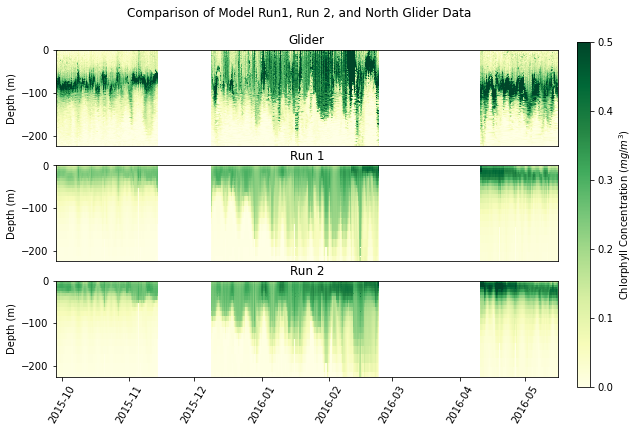

In [25]:
fig = plt.figure(1, figsize=(9,6))
plt.subplot(3,1,2)

im2 = plt.pcolormesh(total_times[:353], chla['Z'][:21], gfloat_accurate[:21,:353], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im3 = plt.pcolormesh(total_times[353:903], chla['Z'][:21], gfloat_accurate[:21,353:903], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im4 = plt.pcolormesh(total_times[903:], chla['Z'][:21],gfloat_accurate[:21,903:], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
plt.xticks([])
plt.ylabel('Depth (m)')
plt.ylim([-225,0])
plt.xlim([total_times[0], total_times[-1]])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Run 1')
#plt.savefig('model1_2_chla_timeseries.png',bbox_inches = 'tight')
plt.subplot(3,1,1)

im2 = plt.pcolormesh(total_times[:353], depth_g[:,0], chla_g[:112,:353], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im3 = plt.pcolormesh(total_times[353:903], depth_g[:,0], chla_g[:112,353:903], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im4 = plt.pcolormesh(total_times[903:], depth_g[:,0], chla_g[:112,903:], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
plt.xticks([])
#cbarc = plt.colorbar(cf)
#plt.xticks(rotation=20)
plt.ylabel('Depth (m)')
plt.title('Glider')
plt.ylim([-225,0])
plt.xlim([total_times[0], total_times[-1]])

plt.subplot(3,1,3)
im2 = plt.pcolormesh(total_times[:353], chla['Z'][:21], gfloat_accurate2[:21,:353], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im3 = plt.pcolormesh(total_times[353:903], chla['Z'][:21], gfloat_accurate2[:21,353:903], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im4 = plt.pcolormesh(total_times[903:], chla['Z'][:21],gfloat_accurate2[:21,903:], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.ylim([-225,0])
plt.xticks(rotation=60)
plt.xlim([total_times[0], total_times[-1]])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Run 2')
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Chlorphyll Concentration ($mg/m^3$)')
plt.suptitle('Comparison of Model Run1, Run 2, and North Glider Data')
plt.savefig('r1vr2_ng_chl_accurate.png', bbox_inches='tight')

In [ ]:
#t = np.array(list(range(109)))
fig = plt.figure(1, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(total_time, chla['Z'][:21],chla_da, vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.ylim([-225,0])
plt.xlim([total_time[0], total_time[-1]])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Chlorophyll Concentration vs Time Within Glider Range')
#plt.savefig('model1_2_chla_timeseries.png',bbox_inches = 'tight')
plt.subplot(2,1,1)
im2 = plt.pcolormesh(total_times[:353], depth_g[:,0], chla_g[:112,:353], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im3 = plt.pcolormesh(total_times[353:903], depth_g[:,0], chla_g[:112,353:903], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
im4 = plt.pcolormesh(total_times[903:], depth_g[:,0], chla_g[:112,903:], shading='auto', cmap = 'YlGn', vmin = 0, vmax = .5)
plt.xticks([])
#cbarc = plt.colorbar(cf)
#plt.xticks(rotation=20)
plt.ylabel('Depth (m)')
plt.title('Chlorophyll vs Time from Glider Data')
plt.ylim([-225,0])
plt.xlim([total_time[0], total_time[-1]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Chlorphyll Concentration ($mg/m^3$)')
plt.savefig('Total_CHLA_Time.png')

fig = plt.figure(4, figsize=(9,5))
plt.subplot(2,1,2)
im = plt.pcolormesh(total_time, chla['Z'][:21], salt_da, vmin=39, vmax=41, cmap = 'YlGnBu', shading = 'Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
#plt.colorbar(label = 'Salinity (psu)')
plt.title('Salinity vs Time Within Glider Range')
#plt.savefig('model1_2_salt_timeseries.png', bbox_inches = 'tight')
plt.ylim([-225,0])
plt.xlim([total_time[0], total_time[-1]])
plt.subplot(2,1,1)
im2 = plt.pcolormesh(total_times[:353], depth_g[:,0], salt_g[:112,:353], shading='auto', cmap = 'YlGnBu', vmin = 39, vmax = 41)
im3 = plt.pcolormesh(total_times[353:903], depth_g[:,0], salt_g[:112,353:903], shading='auto', cmap = 'YlGnBu', vmin = 39, vmax = 41)
im4 = plt.pcolormesh(total_times[903:], depth_g[:,0], salt_g[:112,903:], shading='auto', cmap = 'YlGnBu', vmin = 39, vmax = 41)#
plt.xticks([])
plt.ylim([-225,0])
plt.xlim([total_time[0], total_time[-1]])
plt.ylabel('Depth (m)')
plt.title('Salinity vs Time from Glider Data')
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  'Salinity (psu)')
plt.savefig('Total_Salinity_Time.png')


plt.figure(5, figsize=(8,4))
plt.pcolormesh(total_time, chla['Z'][:21], o2_on_da_u, cmap = 'coolwarm', shading = 'Gouraud', vmin=70, vmax=220)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.title('Onshore Dissolved Oxygen Concentration\n vs Time Within Glider Range')
plt.savefig('model1_2_o2_on_timeseries.png', bbox_inches = 'tight')

plt.figure(6, figsize=(8,4))
plt.pcolormesh(total_time, chla['Z'][:21], o2_off_da_u, cmap = 'coolwarm', shading = 'Gouraud', vmin=70, vmax=220)
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.colorbar(label = r'Dissolved Oxygen ($\mu mol/kg$)')
plt.title('Offshore Dissolved Oxygen Concentration\n vs Time Within Glider Range')
plt.savefig('model1_2_o2_off_timeseries.png', bbox_inches = 'tight')

fig = plt.figure(7, figsize=(8,5))
fig.suptitle('Glider vs Model Theta')
plt.subplot(2,2,3)
im = plt.pcolormesh(total_time, chla['Z'][:21], theta_on_da, cmap = 'jet', shading = 'Gouraud',vmin=22, vmax=30)
plt.xticks(rotation=60)
plt.ylim([-225, 0])
plt.xlim([total_time[0], total_time[-1]])
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Onshore Model')
#plt.savefig('model1_2_theta_on_timeseries.png', bbox_inches = 'tight')
#plt.figure(8, figsize=(8,4))
plt.subplot(2,2,4)
im2 = plt.pcolormesh(total_time, chla['Z'][:21], theta_off_da, cmap = 'jet', shading = 'Gouraud', vmin=22, vmax=30)
plt.xticks(rotation=60)
plt.xlim([total_time[0], total_time[-1]])
plt.ylim([-225, 0])
plt.ylabel('Depth (m)')
#plt.colorbar(label = r'Potential Temperature ($C^\circ$)')
plt.title('Offshore Model')
#plt.savefig('model1_2_theta_off_timeseries.png', bbox_inches = 'tight')
plt.subplot(2,2,1)
im3 = plt.pcolormesh(shore_time_g, depth_g[:,0], np.flip(shore_theta_g,1), vmin=22, vmax=30, cmap='jet')
currentAxis = plt.gca()
currentAxis.add_patch(plt.Rectangle(((total_times)[352], -224), (total_times)[353]-(total_times)[352], 224, facecolor='w'))
currentAxis.add_patch(plt.Rectangle(((total_times)[902], -224), (total_times)[903]-(total_times)[902], 224, facecolor='w'))
plt.xticks([])
plt.ylim([-225, 0])
plt.xlim([total_time[0], total_time[-1]])
plt.ylabel('Depth (m)')
plt.title('Onshore Glider')
plt.subplot(2,2,2)
im4 = plt.pcolormesh(offshore_time_g, depth_g, np.flip(offshore_theta_g,1), vmin=22, vmax=30, cmap='jet')
currentAxis = plt.gca()
currentAxis.add_patch(plt.Rectangle(((total_times)[352], -224), (total_times)[353]-(total_times)[352], 224, facecolor='w'))
currentAxis.add_patch(plt.Rectangle(((total_times)[902], -224), (total_times)[903]-(total_times)[902], 224, facecolor='w'))
plt.xticks([])
plt.ylim([-225, 0])
plt.xlim([total_time[0], total_time[-1]])
plt.ylabel('Depth (m)')
plt.title('Offshore Glider')
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  'Salinity (psu)')
plt.savefig('glider_theta_comp.png')

plt.figure(9, figsize=(10,4))
plt.plot(total_time, theta_on_da[0,:])
plt.xticks(rotation=90)
plt.title('Model Surface Potential Temperature within Glider Range')
plt.plot(total_time, theta_off_da[0,:])
plt.plot(shore_time_g, np.flip(shore_theta_g[1,:]))
plt.plot(offshore_time_g, np.flip(offshore_theta_g[1,:]))
plt.legend(['Onshore Model', 'Offshore Model', 'Onshore Glider', 'Offshore Glider'])
plt.ylabel(r'Potential Temperature ($C^\circ$)')
#plt.ylim([22,32])
plt.savefig('model_surface_theta_glider.png', bbox_inches='tight')

plt.figure(11, figsize=(10,4))
plt.plot(total_time, o2_on_da_u[0,:])
plt.plot(total_time, o2_off_da_u[0,:])
plt.xticks(rotation=90)
plt.title('Model Surface Oxygen Concentration within Glider Range')
plt.legend(['Onshore', 'Offshore'])
plt.ylabel(r'Dissolved Oxygen ($\mu mol/kg$)')
plt.ylim([140, 210])
plt.savefig('model_surface_o2_glider.png', bbox_inches='tight')

In [ ]:
print(nfloat_meta.head())

In [ ]:
print(len(ndates))

In [ ]:
ndates = []
for i in range(len(nDates)):
    ndates.append(np.datetime64(nDates[i]))


In [ ]:
a = chla_15.sel(time = ndates, method='nearest')
print((a['time']))

In [ ]:
print(len(nfloat_meta['Longitude']))

In [ ]:
b = a.sel(XC = nfloat_meta['Longitude'][0], method = 'nearest').sel(YC = nfloat_meta['Latitude'][0], method='nearest')

In [ ]:
print(nDates[154])

In [ ]:
plt.pcolormesh(b['BLGCHL'][0,0,:,:])

In [ ]:
plt.pcolormesh(a['BLGCHL'][0,0,:,:])

In [ ]:
plt.pcolormesh(nDates[:42], chla_15['Z'], nfloat_accurate)
plt.ylim([-200, 0])

In [8]:
ndates = []
for i in range(len(nDates)):
    ndates.append(np.datetime64(nDates[i]))

nfloat_accurate = []
for i in range(154):
    if( i<43):
        temp = chla_152.sel(time=ndates[i], method='nearest').sel(XC = nfloat_meta['Longitude'][i], method='nearest').sel(YC = nfloat_meta['Latitude'][i], method='nearest')
        print(np.shape(temp['BLGCHL']))
        nfloat_accurate.append(temp['BLGCHL'][:])
    elif(i>42 & i< 155):
        temp0 = chla_162.sel(time = ndates[i], method='nearest')
        temp = temp0.sel(XC = nfloat_meta['Longitude'][i], method='nearest').sel(YC = nfloat_meta['Latitude'][i], method='nearest')
        nfloat_accurate.append(temp['BLGCHL'][:])
nfloat_accurate = np.flip(np.rot90(np.array(nfloat_accurate),3),1)
print(np.shape(nfloat_accurate))

(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50, 154)


In [9]:
ndates = []
for i in range(len(nDates)):
    ndates.append(np.datetime64(nDates[i]))

nfloat_accurate2 = []
for i in range(154):
    if( i<43):
        temp = chla_15.sel(time=ndates[i], method='nearest').sel(XC = nfloat_meta['Longitude'][i], method='nearest').sel(YC = nfloat_meta['Latitude'][i], method='nearest')
        print(np.shape(temp['BLGCHL']))
        nfloat_accurate2.append(temp['BLGCHL'][:])
    elif(i>42 & i< 155):
        temp0 = chla_16.sel(time = ndates[i], method='nearest')
        temp = temp0.sel(XC = nfloat_meta['Longitude'][i], method='nearest').sel(YC = nfloat_meta['Latitude'][i], method='nearest')
        nfloat_accurate2.append(temp['BLGCHL'][:])
nfloat_accurate2 = np.flip(np.rot90(np.array(nfloat_accurate2),3),1)


(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)


<ipython-input-11-98067387c8b8>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_chla[:,:168],cmap='YlGn', vmin = 0, vmax = .5)


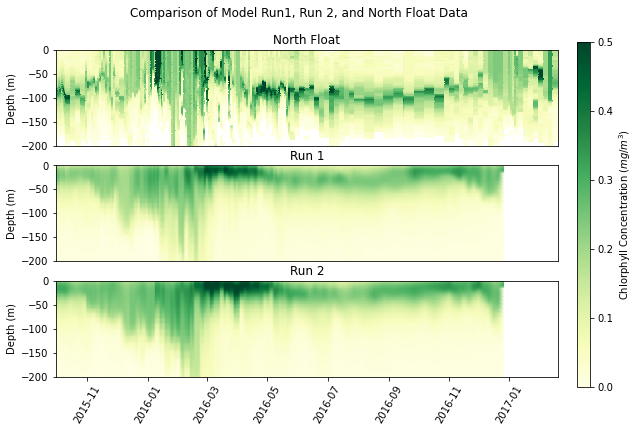

In [11]:
nDates_array = np.array(nDates)
fig = plt.figure(1, figsize=(9,6))
plt.subplot(311)
im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_chla[:,:168],cmap='YlGn', vmin = 0, vmax = .5)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('North Float')
plt.ylabel('Depth (m)')
plt.xticks([])
plt.xlim([nDates_array[0], nDates_array[-1]])
#plt.savefig('Chl_nfloat.png', bbox_inches='tight')
#ax.set_xlim([total_time[0], nDates_array[-1]])
plt.subplot(312)
im2 = plt.pcolormesh(nDates[:154], chla['Z'][:21],nfloat_accurate[:21,:], vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.ylabel('Depth (m)')
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Run 1')
plt.xlim([nDates_array[0], nDates_array[-1]])
plt.xticks([])
plt.subplot(313)
im2 = plt.pcolormesh(nDates[:154], chla['Z'][:21],nfloat_accurate2[:21,:], vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Run 2')
plt.xlim([nDates_array[0], nDates_array[-1]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Chlorphyll Concentration ($mg/m^3$)')
plt.suptitle('Comparison of Model Run1, Run 2, and North Float Data')
plt.savefig('r1vr2_nf_chl_accurate.png',bbox_inches = 'tight')

In [ ]:
print(len(total_times))
print(total_times[700])
print(total_times[0])
def converted_datenum(times):
    new_times = []
    for i in range(len(times)):
        new_times.append(datetime.fromordinal(int(times[i]) - 366) + timedelta(days=times[i]%1))
    return(new_times)
total_times = converted_datenum(total_times)
print(total_times[0])
total_times = np.datetime64(total_times)
print(total_times[0])

In [ ]:
print(total_times[527])
print(total_times[0])


In [17]:
gdates = []
for i in range(len(total_times)):
    gdates.append(np.datetime64(total_times[i]))

gfloat_accurate = []
for i in range(len(total_times)):
    if( i<528):
        temp = chla_152.sel(time=gdates[i], method='nearest').sel(XC = total_longs[i], method='nearest').sel(YC = total_lats[i], method='nearest')
        print(np.shape(temp['BLGCHL']))
        gfloat_accurate.append(np.array(temp['BLGCHL'][:]))
    elif(i>528):
        temp0 = chla_162.sel(time = gdates[i], method='nearest')
        temp = temp0.sel(XC = total_longs[i], method='nearest').sel(YC = total_lats[i], method='nearest')
        gfloat_accurate.append(np.array(temp['BLGCHL'][:]))
gfloat_accurate = np.flip(np.rot90(np.array(gfloat_accurate),3),1)
print(np.shape(gfloat_accurate))

(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,

In [23]:
gdates = []
for i in range(len(total_times)):
    gdates.append(np.datetime64(total_times[i]))

gfloat_accurate2 = []
for i in range(len(total_times)):
    if( i<528):
        temp = chla_15.sel(time=gdates[i], method='nearest').sel(XC = total_longs[i], method='nearest').sel(YC = total_lats[i], method='nearest')
        print(np.shape(temp['BLGCHL']))
        gfloat_accurate2.append(np.array(temp['BLGCHL'][:]))
    elif(i>528):
        temp0 = chla_16.sel(time = gdates[i], method='nearest')
        temp = temp0.sel(XC = total_longs[i], method='nearest').sel(YC = total_lats[i], method='nearest')
        gfloat_accurate2.append(np.array(temp['BLGCHL'][:]))
gfloat_accurate2 = np.flip(np.rot90(np.array(gfloat_accurate2),3),1)
print(np.shape(gfloat_accurate2))

(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,

<ipython-input-12-40e0577c6c60>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(gdates, chla_15['Z'], gfloat_accurate, vmin=0, vmax=.5, cmap='YlGn')


(-200.0, 0.0)

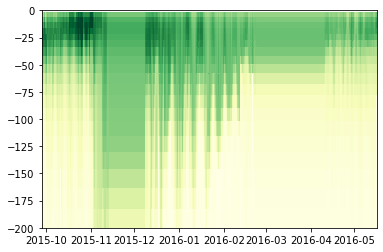

In [12]:
plt.pcolormesh(gdates, chla_15['Z'], gfloat_accurate, vmin=0, vmax=.5, cmap='YlGn')
plt.ylim([-200,0])

In [ ]:
print(np.shape(nfloat_accurate))
np.flim

In [ ]:
print(chla['drF'][:])
sum1=0
sum2=0
for i in range(50):
    sum1+=chla['drF'][i]
    print(sum1, i , 'model')
print(nfloat_meta['Pressure'][213])

In [ ]:
print(np.shape(np.flip(nfloat_accurate,1)))

In [ ]:
nfloat_weighted = np.flip(nfloat_accurate,1)
temp = 0
nfloat_msum = []
for i in range(154):
    temp = nfloat_weighted[:20,i] * chla['drF'][:20]
    nfloat_msum.append(np.sum(temp))
print(np.shape(nfloat_chla[:213,:168]))
nfloat_isum = []
temp = 0
for i in range(168):
    temp = np.nansum(nfloat_chla[:213, i])
    temp = temp/(np.count_nonzero(~np.isnan(nfloat_chla[:213,i])))
    temp = temp * 213.5
    nfloat_isum.append(temp)

In [ ]:
plt.figure(1)
plt.plot(nDates[:154],nfloat_msum)
plt.plot(nDates, nfloat_isum, alpha = .75)
plt.legend(['Model', 'Float'])
plt.xticks(rotation=60)
plt.ylabel(r'Detph Integrated Chlorphyll Concentration ($mg/m^2$)')
plt.title('North Float')
plt.savefig('figures/nf_di_chl.png')

In [ ]:

plt.figure(1)
plt.pcolormesh(nDates[:154], chla_15['Z'], np.flip(nfloat_accurate,1), vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.ylim([-200, 0])
plt.colorbar()
plt.xticks(rotation=60)
plt.xlim([nDates[0], nDates[154]])
plt.figure(2)
plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_chla[:,:168],cmap='YlGn', vmin = 0, vmax = .5)
plt.ylim([-200,0])
plt.xlim([nDates[0], nDates[154]])
plt.colorbar()

In [ ]:
b = a.where(a.XC == nfloat_meta['Longitude'][0]).where(a.YC == nfloat_meta['Latitude'][0])

In [ ]:
c = np.array(chla_15['BLGCHL'][:,:,1000:,:])
c[c==0] = np.float('NaN')
d = np.nanmean(c,3)
e = np.nanmean(d,2)

In [ ]:
e = np.rot90(e, 3)

In [ ]:
plt.pcolormesh(chla15_da_nf)
print(np.shape(chla15_da_nf), np.shape(chla_15['Z'][21]), np.shape(chla_15['time']))

In [ ]:
plt.pcolormesh(chla_15['time'], chla_15['Z'][:21], chla15_da_nf)
#plt.ylim([-200,0])